In [1]:
%matplotlib inline
import httplib2
import oauth2
import urllib3
import types
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from causalinference import CausalModel
import httplib
import base64
import csv
from statsmodels.formula.api import ols
import statsmodels.api as sm
import math
from collections import defaultdict
from scipy import stats

data_analysis_file_name = './csv_files/formatted_analysis2_df_2017_12_12_upwork_analysis_unitedstates_allskills.csv'
output_file_name = './analyses_output/descriptives2_2017_12_12_upwork_analysis_unitedstates_allskills.txt'
        
merged = pd.read_csv(data_analysis_file_name)

# Merged2 refers to the omitted dataset
merged2 = merged[#(merged['final_gender'] == 'unknown') | 
                 #(merged['final_gender'] == 'ambiguous') | 
                  #(merged['new_age_range_id'] == "0") |
                  #(merged['new_age_range_id'] == "error") |
                  (merged['education'] == 'None') |
                  (merged['education'] == 'Other') | 
                  (merged['education'] == 'error') | 
                  (merged['work_experience'] == "error") |
                 (merged['job_category'] == "none") |
                (merged['gender_computer'].isnull()) |
                (merged['gender_computer'] == None) | 
                (merged['gender_computer'] == 'unisex')]
        
# Merged refers to the final dataset (copy these from Causal Inference python file)
#merged = merged[merged['final_gender'] != 'unknown']
#merged = merged[merged['final_gender'] != 'ambiguous']
#merged = merged[merged['new_age_range_id'] != "0"]
#merged = merged[merged['new_age_range_id'] != "error"]
merged = merged[merged['education'] != 'None']
merged = merged[merged['education'] != 'Other']
merged = merged[merged['education'] != 'error']

merged = merged[merged['work_experience'] != "error"]
merged = merged[merged['job_category'] != "none"]
merged = merged[merged['gender_computer'].notnull()]
merged = merged[merged['gender_computer'] != None]
merged = merged[merged['gender_computer'] != 'unisex']
merged['work_experience'] = merged['work_experience'].astype('float')

def make_dummy_gender(row):
    if row['gender_computer'] == "female":
        return 0
    elif row['gender_computer'] == "male":
        return 1
    
def make_dummy_gender_female(row):
    if row['gender_computer'] == "male":
        return 0
    elif row['gender_computer'] == "female":
        return 1
    
def estimate_hourly_revenue(row):
    return row['bill_rate'] * row['hours_worked']
    
merged['dummy_gender'] = merged.apply(make_dummy_gender, axis=1)
merged['dummy_gender_female'] = merged.apply(make_dummy_gender_female, axis=1)
merged['estimated_hourly_revenue'] = merged.apply(estimate_hourly_revenue, axis=1)

# Determining outliers

# Outliers by SD
mean_bill_rate = np.mean(merged['bill_rate'])
sd_bill_rate = np.std(merged['bill_rate'])
merged['outlier2sd'] = merged['bill_rate'] >= mean_bill_rate + 2*sd_bill_rate 
merged['outlier1sd'] = merged['bill_rate'] >= mean_bill_rate + sd_bill_rate 

# Outliers by IQR

percentile_25 = merged.bill_rate.quantile(0.25)
percentile_75 = merged.bill_rate.quantile(0.75)
iqr = stats.iqr(merged.bill_rate)

def check_outlier_iqr(row):
    if (row['bill_rate'] <= percentile_25 - (1.5 * iqr) or
        row['bill_rate'] >= percentile_75 + (1.5 * iqr)):
        return True
    else:
        return False

merged['outlier_iqr'] = merged.apply(check_outlier_iqr, axis=1)

# Checking number of workers who were omitted from dataset
print (len(merged2))
print ("Number of women: {0}").format(len(merged2[merged2['gender_computer'] == 'female']))
print ("Number of men: {0}").format(len(merged[merged['gender_computer'] == 'male']))

merged_have_worked = merged[merged['hours_worked'] > 0]


/home/ecf384/.conda/envs/eureka2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


7499
Number of women: 1375
Number of men: 24581


In [13]:
print len(merged[merged['outlier_iqr'] == True])

3353


In [27]:
merged_no_outliers_sd = merged[merged['outlier2sd'] == False]
merged_no_outliers_sd_female = merged_no_outliers_sd[merged_no_outliers_sd['gender_computer'] == 'female']
merged_no_outliers_sd_male = merged_no_outliers_sd[merged_no_outliers_sd['gender_computer'] == 'male']
merged_no_outliers_sd.describe()

,Unnamed: 0,user_count,bill_rate,job_category_id,jobs_completed,hours_worked,feedback_score,no_reviews,eng_skill,agency,work_experience,dummy_gender,dummy_gender_female,estimated_hourly_revenue
count,46222.000000,46222.000000,46222.000000,46222.000000,46222.000000,46222.000000,46222.000000,46222.00000,7039.000000,46222.000000,46222.000000,46222.000000,46222.000000,46222.000000
mean,27834.747285,27835.747285,36.005402,6.303470,4.951798,79.904953,1.076075,3.18965,4.961926,0.025659,5.369348,0.504349,0.495651,2709.738410
std,16004.216829,16004.216829,22.036273,3.418332,28.084689,569.627976,2.021730,17.49487,0.255042,0.158117,6.726253,0.499986,0.499986,19542.345289
min,0.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,13991.250000,13992.250000,20.000000,3.000000,0.000000,0.000000,0.000000,0.00000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27980.500000,27981.500000,30.000000,7.000000,0.000000,0.000000,0.000000,0.00000,5.000000,0.000000,3.000000,1.000000,0.000000,0.000000
75%,41546.750000,41547.750000,50.000000,9.000000,1.000000,0.000000,0.000000,0.00000,5.000000,0.000000,8.000000,1.000000,1.000000,0.000000
max,55516.000000,55517.000000,119.000000,12.000000,1223.000000,37007.033334,5.000000,811.00000,5.000000,1.000000,79.000000,1.000000,1.000000,774729.999997


In [28]:
merged_no_outliers_iqr = merged[merged['outlier_iqr'] == False]
merged_no_outliers_iqr_female = merged_no_outliers_iqr[merged_no_outliers_iqr['gender_computer'] == 'female']
merged_no_outliers_iqr_male = merged_no_outliers_iqr[merged_no_outliers_iqr['gender_computer'] == 'male']
merged_no_outliers_iqr.describe()

,Unnamed: 0,user_count,bill_rate,job_category_id,jobs_completed,hours_worked,feedback_score,no_reviews,eng_skill,agency,work_experience,dummy_gender,dummy_gender_female,estimated_hourly_revenue
count,44666.000000,44666.000000,44666.000000,44666.000000,44666.000000,44666.000000,44666.000000,44666.000000,6766.000000,44666.000000,44666.000000,44666.000000,44666.000000,44666.000000
mean,27947.661532,27948.661532,33.757280,6.316706,4.936708,80.860151,1.075823,3.173264,4.960686,0.025030,5.308557,0.497963,0.502037,2618.216465
std,15957.687249,15957.687249,18.755392,3.424665,28.214612,576.506343,2.021226,17.501118,0.259496,0.156219,6.677915,0.500001,0.500001,18925.337070
min,0.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,14137.500000,14138.500000,20.000000,3.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,28245.500000,28246.500000,30.000000,7.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,3.000000,0.000000,1.000000,0.000000
75%,41543.750000,41544.750000,45.000000,9.000000,1.000000,0.000000,0.000000,0.000000,5.000000,0.000000,8.000000,1.000000,1.000000,0.000000
max,55516.000000,55517.000000,94.440000,12.000000,1223.000000,37007.033334,5.000000,811.000000,5.000000,1.000000,79.000000,1.000000,1.000000,774729.999997


## Measuring Skewness of Dataset

In [22]:
# Bill rate
skew_bill_rate = stats.skew(np.array(merged.bill_rate))
skew_p_bill_rate = stats.skewtest(np.array(merged.bill_rate))
kurtosis_bill_rate = stats.kurtosis(np.array(merged.bill_rate))
kurtosis_p_bill_rate = stats.kurtosistest(np.array(merged.bill_rate))
print ("Skew: {0}, {1} and Kurtosis for bill rate: {2}, {3}").format(skew_bill_rate, skew_p_bill_rate, kurtosis_bill_rate, kurtosis_p_bill_rate)

# Offline work experience
skew_work_experience = stats.skew(np.array(merged.work_experience))
skew_p_work_experience = stats.skewtest(np.array(merged.work_experience))
kurtosis_work_experience = stats.kurtosis(np.array(merged.work_experience))
kurtosis_p_work_experience = stats.kurtosistest(np.array(merged.work_experience))
print ("Skew: {0}, {1} and Kurtosis for work experience: {2}, {3}").format(skew_work_experience, skew_p_work_experience, kurtosis_work_experience, kurtosis_p_work_experience)

# Hours worked on Upwork
skew_hours_worked = stats.skew(np.array(merged_have_worked.hours_worked))
skew_p_hours_worked = stats.skewtest(np.array(merged_have_worked.hours_worked))
kurtosis_hours_worked = stats.kurtosis(np.array(merged_have_worked.hours_worked))
kurtosis_p_hours_worked = stats.kurtosistest(np.array(merged_have_worked.hours_worked))

print ("Skew: {0}, {1} and Kurtosis for hours worked: {2}, {3}").format(skew_hours_worked, skew_p_hours_worked, kurtosis_hours_worked, kurtosis_p_hours_worked)

Skew: 7.52259083391, SkewtestResult(statistic=213.1156209928532, pvalue=0.0) and Kurtosis for bill rate: 131.176527884, KurtosistestResult(statistic=140.40763036217157, pvalue=0.0)
Skew: 1.88005894158, SkewtestResult(statistic=114.80420857369074, pvalue=0.0) and Kurtosis for work experience: 4.53204853957, KurtosistestResult(statistic=69.77806161107253, pvalue=0.0)
Skew: 8.70878365551, SkewtestResult(statistic=100.93641305189136, pvalue=0.0) and Kurtosis for hours worked: 141.107489917, KurtosistestResult(statistic=63.875594739705534, pvalue=0.0)


In [23]:
merged_have_worked.estimated_hourly_revenue.describe()
#np.median(merged_have_worked.estimated_hourly_revenue)

count    9.747000e+03
mean     1.428132e+04
std      4.698941e+04
min      1.333333e+00
25%      2.795833e+02
50%      1.327667e+03
75%      7.892187e+03
max      1.192856e+06
Name: estimated_hourly_revenue, dtype: float64

## Distribution of Bill Rate

In [8]:
# Create a distribution table

just_females = merged[merged['gender_computer'] == 'female']
just_males = merged[merged['gender_computer'] == 'male']
just_females_worked = merged_have_worked[merged_have_worked['gender_computer'] == 'female']
just_males_worked = merged_have_worked[merged_have_worked['gender_computer'] == 'male']
bins_bill_rate = [0,10,20,30,40,50,60,70,80,100,1000]
bins_revenue = [0, 100, 200, 500, 1000, 2000, 3000, 4000, 5000, 10000]

print stats.levene(just_females_worked.estimated_hourly_revenue, just_males_worked.estimated_hourly_revenue)
print "Females"
print "Revenue"
print np.median(just_females_worked.estimated_hourly_revenue)
print np.mean(just_females_worked.estimated_hourly_revenue)
print np.std(just_females_worked.estimated_hourly_revenue)
print "Hours Worked"
print np.median(just_females_worked.hours_worked)
print np.mean(just_females_worked.hours_worked)
print np.std(just_females_worked.hours_worked)
print "Males"
print "Revenue"
print np.median(just_males_worked.estimated_hourly_revenue)
print np.mean(just_males_worked.estimated_hourly_revenue)
print np.std(just_males_worked.estimated_hourly_revenue)
print "Hours Worked"
print np.median(just_males_worked.hours_worked)
print np.mean(just_males_worked.hours_worked)
print np.std(just_males_worked.hours_worked)

# Running Mann-Whitney U on non-transformed revenue data
print "Mann Whitney U: {0}".format(stats.mannwhitneyu(just_females_worked.estimated_hourly_revenue, just_males_worked.estimated_hourly_revenue))

# Transforming revenue to a normal distribution 
transformed_revenue = stats.boxcox(merged_have_worked.estimated_hourly_revenue)
print "This is normality test: {0}".format(stats.mstats.normaltest(transformed_revenue[0]))

# Assign transformed revenue to men and women in the dataset
merged_have_worked['transformed_revenue'] = transformed_revenue[0]

# Return mean, median, sd of transformed data
female_transformed_revenue = merged_have_worked[merged_have_worked['gender_computer'] == 'female'].transformed_revenue
male_transformed_revenue = merged_have_worked[merged_have_worked['gender_computer'] == 'male'].transformed_revenue
print "Females"
print np.mean(female_transformed_revenue)
print np.median(female_transformed_revenue)
print np.std(female_transformed_revenue)

print "Males"
print np.mean(male_transformed_revenue)
print np.median(male_transformed_revenue)
print np.std(male_transformed_revenue)

# Running t-test on transformed revenue values
print "This is t-test: {0}".format(stats.ttest_ind(female_transformed_revenue, male_transformed_revenue))

def return_histogram(dimension, bins, df):
    histogram = np.histogram(np.array(df[dimension]), bins=bins)
    return histogram[0]

def create_freq_table(bins, data, column_name):
    labels = []
    index = 0
    for n in bins:
        if index + 1 > len(bins) - 1:
            break
        else: 
            label_str = str(n) + '-' + str(bins[index+1])
            labels.append(label_str)
            index += 1
    
    index = labels
    d = data
    df = pd.DataFrame(data=d, index=index, columns=[column_name])
    
    return df

female_bill_rate_df = return_histogram('bill_rate', bins_bill_rate, just_females)
male_bill_rate_df = return_histogram('bill_rate', bins_bill_rate, just_males)
female_revenue_df = return_histogram('estimated_hourly_revenue', bins_revenue, just_females_worked)
male_revenue_df = return_histogram('estimated_hourly_revenue', bins_revenue, just_males_worked)

# Finding median revenue for men and women 
print np.median(just_females_worked.estimated_hourly_revenue)
print np.median(just_males_worked.estimated_hourly_revenue)

print merged_have_worked.estimated_hourly_revenue.describe()

#create_freq_table(bins_bill_rate, female_bill_rate_df, 'Females')
#create_freq_table(bins_bill_rate, male_bill_rate_df, 'Males')
#create_freq_table(bins_revenue, female_revenue_df, 'Females')
create_freq_table(bins_revenue, male_revenue_df, 'Males')

def return_worker_id(df, dimension, value):
    print df.worker_idf[df[dimension] == value]

return_worker_id(merged, )


LeveneResult(statistic=4.1225596409382241, pvalue=0.042342110599236996)
Females
Revenue
1386.6666658
13382.3914515
40896.2974079
Hours Worked
48.83333333
436.545574095
1325.70262871
Males
Revenue
1278.08333387
15276.4357018
52900.2945174
Hours Worked
32.499999995
335.42289912
1049.90144857
Mann Whitney U: MannwhitneyuResult(statistic=11741437.5, pvalue=0.22794702242058973)
This is normality test: NormaltestResult(statistic=223.54467587399031, pvalue=2.8700562236829698e-49)
Females
6.7401574764
6.71751835728
1.93515461064
Males
6.72957414334
6.64729028186
1.95509244526
This is t-test: Ttest_indResult(statistic=0.26827660022005395, pvalue=0.78849209501310902)
1386.6666658
1278.08333387
count    9.747000e+03
mean     1.428132e+04
std      4.698941e+04
min      1.333333e+00
25%      2.795833e+02
50%      1.327667e+03
75%      7.892187e+03
max      1.192856e+06
Name: estimated_hourly_revenue, dtype: float64


/home/ecf384/.conda/envs/eureka2/lib/python2.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Males
0-100,535
100-200,417
200-500,639
500-1000,535
1000-2000,499
2000-3000,276
3000-4000,167
4000-5000,138
5000-10000,371


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efd38328390>]], dtype=object)

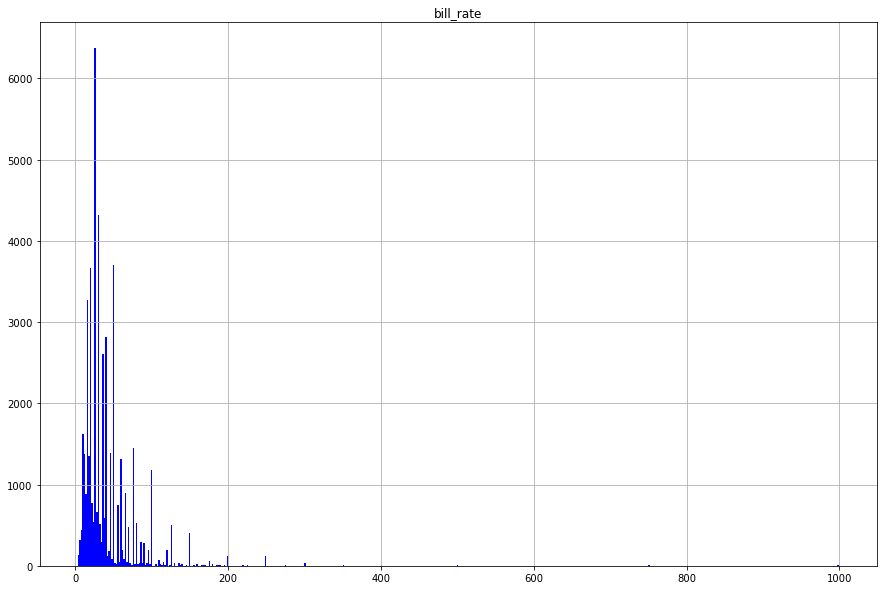

In [5]:
merged.hist(column='bill_rate', figsize=(15,10), color="blue", bins=500)

In [42]:
female_df

,Female
0-10,592
10-20,5111
20-30,6474
30-40,4174
40-50,2103
50-60,1826
60-70,1001
70-80,745
80-100,474
100-1000,938


In [43]:
male_df

,Male
0-10,537
10-20,3420
20-30,5392
30-40,4186
40-50,2438
50-60,2669
60-70,1535
70-80,1237
80-100,1007
100-1000,2160


## Distribution of Hourly Revenue 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efcfc0047d0>]], dtype=object)

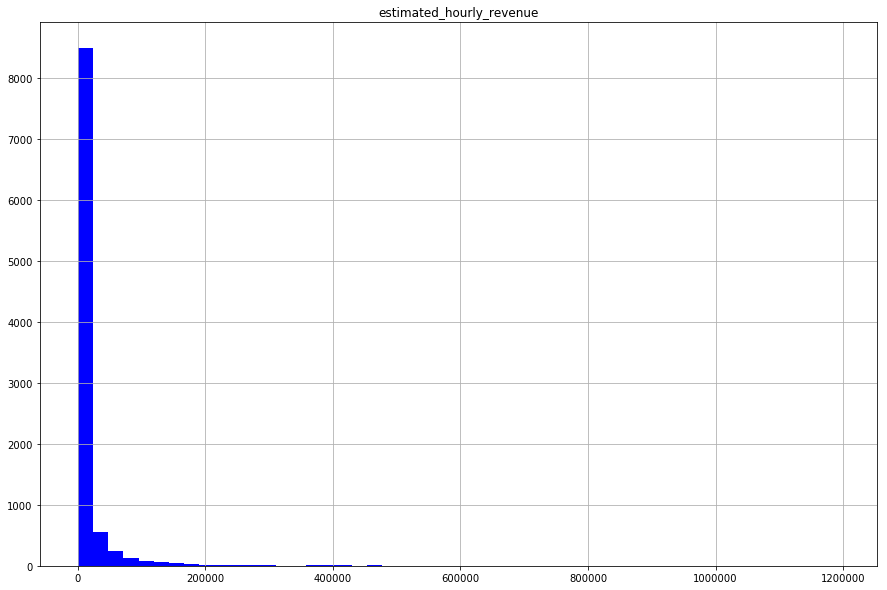

In [64]:
merged_have_worked.hist(column='estimated_hourly_revenue', figsize=(15,10), color="blue", bins=50)

## Outliers in the Dataset

In [25]:
outliers_2sd = merged[merged['outlier2sd'] == True]
outliers_1sd = merged[merged['outlier1sd'] == True]

print ("----Outliers: 2 standard deviations-----")
print ("Number of outliers: {0}").format(len(outliers_2sd))
print ("Percentage outliers: {0}").format(float(len(outliers_2sd))/float(len(merged)) * 100)
print ("Mean for outliers: {0}").format(np.mean(np.array(outliers_2sd['bill_rate'])))
print ("Median for outliers: {0}").format(np.median(np.array(outliers_2sd['bill_rate'])))
print ("SD for outliers: {0}").format(np.std(np.array(outliers_2sd['bill_rate'])))

print ("----Outliers: 1 standard deviation-----")
print ("Percentage outliers: {0}").format(float(len(outliers_1sd))/float(len(merged)) * 100)
print ("Mean for outliers: {0}").format(np.mean(np.array(outliers_1sd['bill_rate'])))
print ("SD for outliers: {0}").format(np.std(np.array(outliers_1sd['bill_rate'])))

----Outliers: 2 standard deviations-----
Number of outliers: 1797
Percentage outliers: 3.74226868531
Mean for outliers: 172.312370618
Median for outliers: 150.0
SD for outliers: 101.177316921
----Outliers: 1 standard deviation-----
Percentage outliers: 8.47789416689
Mean for outliers: 129.911449275
SD for outliers: 77.2552132908


In [ ]:
outliers_iqr = merged[merge]

## Scatterplot of Upwork/BLS Comparison

[[ 1.          0.12853959]
 [ 0.12853959  1.        ]]


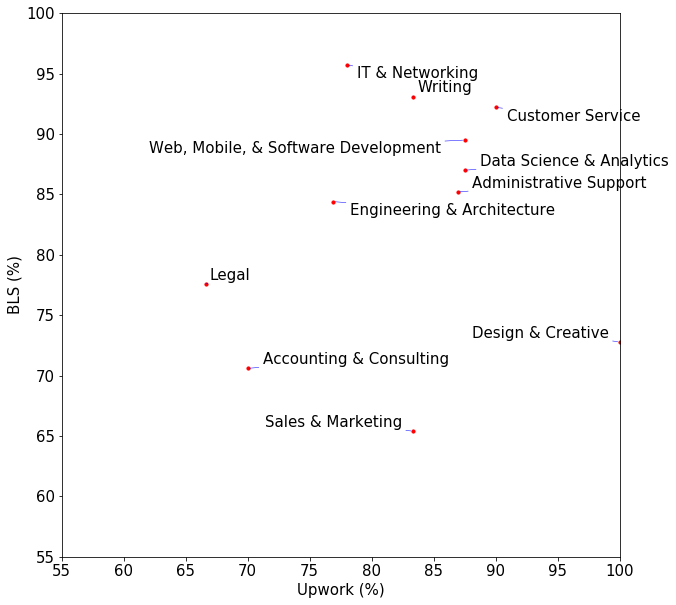

In [7]:
from adjustText import adjust_text
n=['Accounting & Consulting', 'Administrative Support', 'Customer Service',
  'Data Science & Analytics', 'Design & Creative', 'Engineering & Architecture',
  'IT & Networking', 'Legal', 'Sales & Marketing', 
  'Web, Mobile, & Software Development', 'Writing']

fig, ax = plt.subplots()
upwork_x = [48.79, 77.89, 64.55, 26.39, 44.21, 18.33, 16.96, 58.51, 48.39, 19.12, 64.70]
bls_x = [61.47, 94.03, 64.05, 47.90, 50.68, 12.78, 25.34, 40.13, 43.76, 25.81, 46.67]
# y represents earnings (median)
upwork_y = [70.0, 86.96, 90.0, 87.5, 100.0, 76.9, 78.0, 66.67, 83.33, 87.5, 83.33]
bls_y = [70.60, 85.20, 92.20, 87.00, 72.80, 84.40, 95.70, 77.60, 65.40, 89.50, 93.10]
#ax.scatter(upwork_x, bls_x, s=10, c='b', marker="s", label='first')
ax.scatter(upwork_y, bls_y, s=10, c='r', marker="o", label='second')

texts_representation = []
texts_earnings = []
#for x, y, s in zip(upwork_x, bls_x, n):
    #texts_representation.append(plt.text(x, y, s))

for x, y, s in zip(upwork_y, bls_y, n):
    texts_earnings.append(plt.text(x, y, s))

#adjust_text(texts_representation, only_move='y', arrowprops=dict(arrowstyle="-", color='b', lw=0.5))
adjust_text(texts_earnings, only_move='y', arrowprops=dict(arrowstyle="-", color='b', lw=0.5))

# Make axes the same for comparison
plt.xlim(55, 100)
plt.ylim(55, 100)
#plt.title('Average Female Earnings as a Percentage of Average Male Earnings')

# Compute correlation between BLS and Upwork datasets
print np.corrcoef(upwork_y, bls_y)

from pylab import rcParams
rcParams['figure.figsize'] = 10,10
plt.rcParams.update({'font.size': 15})
plt.rcParams["font.family"] = "sans-serif"
ax.set_xlabel('Upwork (%)')
ax.set_ylabel('BLS (%)')
#ax.set_ylabel('Average Female Earnings as Percentage of Average Male Earnings (%)')
plt.show()

### Scatterplot for Representation of Women in BLS/Upwork datasets

[[ 1.          0.82032271]
 [ 0.82032271  1.        ]]


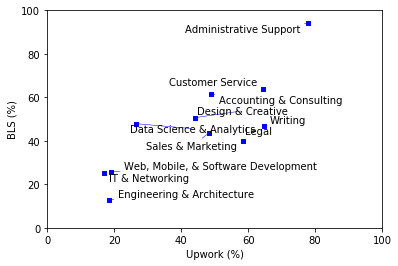

In [6]:
from adjustText import adjust_text
n=['Accounting & Consulting', 'Administrative Support', 'Customer Service',
  'Data Science & Analytics', 'Design & Creative', 'Engineering & Architecture',
  'IT & Networking', 'Legal', 'Sales & Marketing', 
  'Web, Mobile, & Software Development', 'Writing']

fig, ax = plt.subplots()
upwork_x = [48.79, 77.89, 64.55, 26.39, 44.21, 18.33, 16.96, 58.51, 48.39, 19.12, 64.70]
bls_x = [61.47, 94.03, 64.05, 47.90, 50.68, 12.78, 25.34, 40.13, 43.76, 25.81, 46.67]
upwork_y = [73.11, 86.39, 69.46, 84.93, 93.35, 89.34, 80.89, 58.90, 84.35, 85.95, 86.30]
bls_y = [70.60, 85.20, 92.20, 87.00, 72.80, 84.40, 95.70, 77.60, 65.40, 89.50, 93.10]
ax.scatter(upwork_x, bls_x, s=10, c='b', marker="s", label='first')

# Compute correlation
print np.corrcoef(upwork_x, bls_x)

texts_representation = []
for x, y, s in zip(upwork_x, bls_x, n):
    texts_representation.append(plt.text(x, y, s))


adjust_text(texts_representation, only_move='y', arrowprops=dict(arrowstyle="-", color='b', lw=0.5))

# Make axes the same for comparison
plt.xlim(0, 100)
plt.ylim(0, 100)
#plt.title('Average Female Earnings as a Percentage of Average Male Earnings')

from pylab import rcParams
rcParams['figure.figsize'] = 10,10
plt.rcParams.update({'font.size': 15})
plt.rcParams["font.family"] = "sans-serif"
ax.set_xlabel('Upwork (%)')
ax.set_ylabel('BLS (%)')
plt.show()

## Testing for significance between means of estimated hourly revenue for men and women

In [8]:
from scipy import stats

merged_have_worked = merged[merged['hours_worked'] > 0]

mean_hourly_revenue = np.mean(merged_have_worked.estimated_hourly_revenue)
median_hourly_revenue = np.median(merged_have_worked.estimated_hourly_revenue)
std_hourly_revenue = np.std(merged_have_worked.estimated_hourly_revenue)

women_have_worked = merged_have_worked[merged_have_worked['gender_computer'] == 'female']
men_have_worked = merged_have_worked[merged_have_worked['gender_computer'] == 'male']

print ("This many women have worked: {0}").format(len(women_have_worked))
print ("This many men have worked: {0}").format(len(men_have_worked))

print ("Skew for women {0}").format(stats.skew(np.array(women_have_worked.hours_worked)))
print ("Skew for men {0}").format(stats.skew(np.array(men_have_worked.hours_worked)))
print ("Median hours worked by women: {0}").format(np.median(women_have_worked.hours_worked))
print ("Median hours worked by men: {0}").format(np.median(men_have_worked.hours_worked))

female_hourly_revenue = np.median(women_have_worked.estimated_hourly_revenue)
female_std_revenue = np.std(women_have_worked.estimated_hourly_revenue)
male_hourly_revenue = np.median(men_have_worked.estimated_hourly_revenue)
male_std_revenue = np.std(men_have_worked.estimated_hourly_revenue)

print("Mean hourly revenue: {0}").format(mean_hourly_revenue)
print("Median hourly revenue: {0}").format(median_hourly_revenue)
print ("Std hourly revenue: {0}").format(std_hourly_revenue)
print("Female hourly revenue: {0}").format(female_hourly_revenue)
print("Female std revenue: {0}").format(female_std_revenue)
print("Male hourly revenue: {0}").format(male_hourly_revenue)
print("Male std revenue: {0}").format(male_std_revenue)

#stats.ttest_ind(women_have_worked.estimated_hourly_revenue, men_have_worked.estimated_hourly_revenue)
stats.mannwhitneyu(women_have_worked.estimated_hourly_revenue, men_have_worked.estimated_hourly_revenue)


This many women have worked: 5121
This many men have worked: 4626
Skew for women 9.00848761153
Skew for men 7.4906197085
Median hours worked by women: 48.83333333
Median hours worked by men: 32.499999995
Mean hourly revenue: 14281.3191935
Median hourly revenue: 1327.66666662
Std hourly revenue: 46987.0034126
Female hourly revenue: 1386.6666658
Female std revenue: 40896.2974079
Male hourly revenue: 1278.08333387
Male std revenue: 52900.2945174


MannwhitneyuResult(statistic=11741437.5, pvalue=0.22794702242058973)

## Relationship between hourly bill rate and number of hours worked

[[ 1.         -0.03213927]
 [-0.03213927  1.        ]]


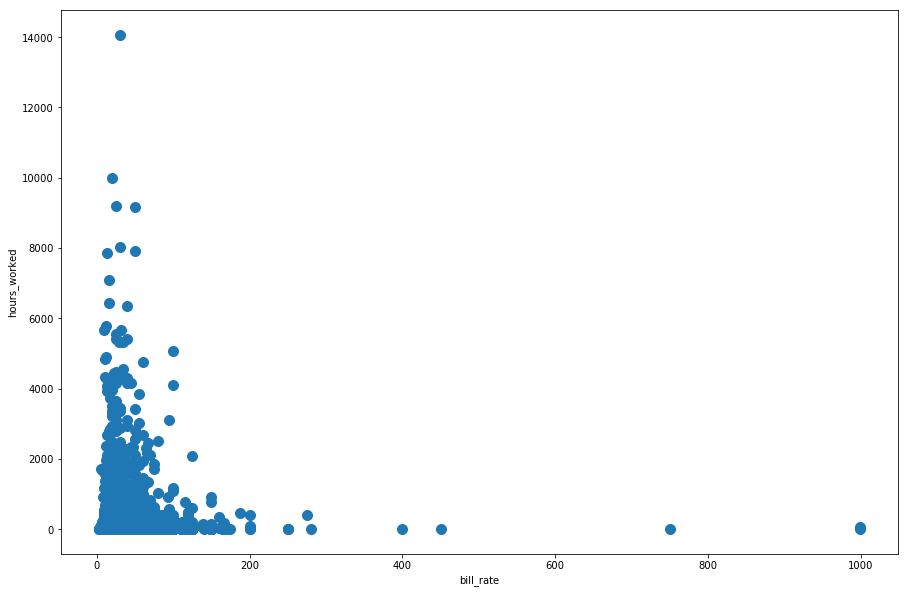

In [2]:
merged_worked = merged[merged['jobs_completed'] > 0]

merged_worked_writing = merged_worked[merged_worked['job_category'] == 'Writing']

merged_worked_writing.plot(kind='scatter', x='bill_rate', y='hours_worked', figsize=(15, 10), s=100)

cross_correlation_df = merged_worked[['bill_rate', 'hours_worked']]

correlation_matrix = np.corrcoef(cross_correlation_df.T)
print correlation_matrix


In [3]:
model = ols("bill_rate ~ dummy_gender + ", merged).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(model.summary())
print (anova_table)

print (model.params)

PatsyError: expected a noun, but instead the expression ended
    bill_rate ~ dummy_gender +
                             ^

## Correlation Table

In [4]:
cross_correlation_df = merged[['dummy_gender', 'dummy_gender_female', 'bill_rate', 'work_experience']]

correlation_matrix = np.corrcoef(cross_correlation_df.T)
print correlation_matrix

[[ 1.         -1.          0.1377484  -0.01386145]
 [-1.          1.         -0.1377484   0.01386145]
 [ 0.1377484  -0.1377484   1.          0.1343503 ]
 [-0.01386145  0.01386145  0.1343503   1.        ]]


### Correlation between pay gap and employability of women in different jobs 

In [5]:
cross_correlation_df = merged[['dummy_gender', 'dummy_gender_female', 'bill_rate', 'work_experience']]

correlation_matrix = np.corrcoef(cross_correlation_df.T)
print correlation_matrix

[[ 1.         -1.          0.1377484  -0.01386145]
 [-1.          1.         -0.1377484   0.01386145]
 [ 0.1377484  -0.1377484   1.          0.1343503 ]
 [-0.01386145  0.01386145  0.1343503   1.        ]]


## Creating Dumbbell Chart

In [62]:
# Create arrays of the average hourly bill rate in each job category

job_categories_list = ["Accounting & Consulting", "Admin Support", "Customer Service", "Data Science & Analytics",
                      "Design & Creative", "Engineering & Architecture", "IT & Networking", 
                      "Legal", "Sales & Marketing", "Translation", "Web, Mobile & Software Dev", 
                      "Writing"]

female_rates = []
male_rates = []

for job in job_categories_list:
    # Calculate female earnings
    df_female_dumbbell = merged[(merged['job_category'] == job) & (merged['gender_computer'] == "female")]
    female_median = round(np.median(df_female_dumbbell['bill_rate']), 0)
    female_median = int(female_median)

    # Calculate male earnings
    df_male_dumbbell = merged[(merged['job_category'] == job) & (merged['gender_computer'] == "male")]
    male_median = round(np.median(df_male_dumbbell['bill_rate']), 0)
    male_median = int(male_median)

    female_rates.append(female_median)
    male_rates.append(male_median)

print (female_rates)
print (male_rates)

[35, 20, 18, 35, 30, 30, 39, 35, 38, 25, 35, 25]
[50, 23, 20, 40, 30, 39, 50, 53, 45, 25, 40, 30]


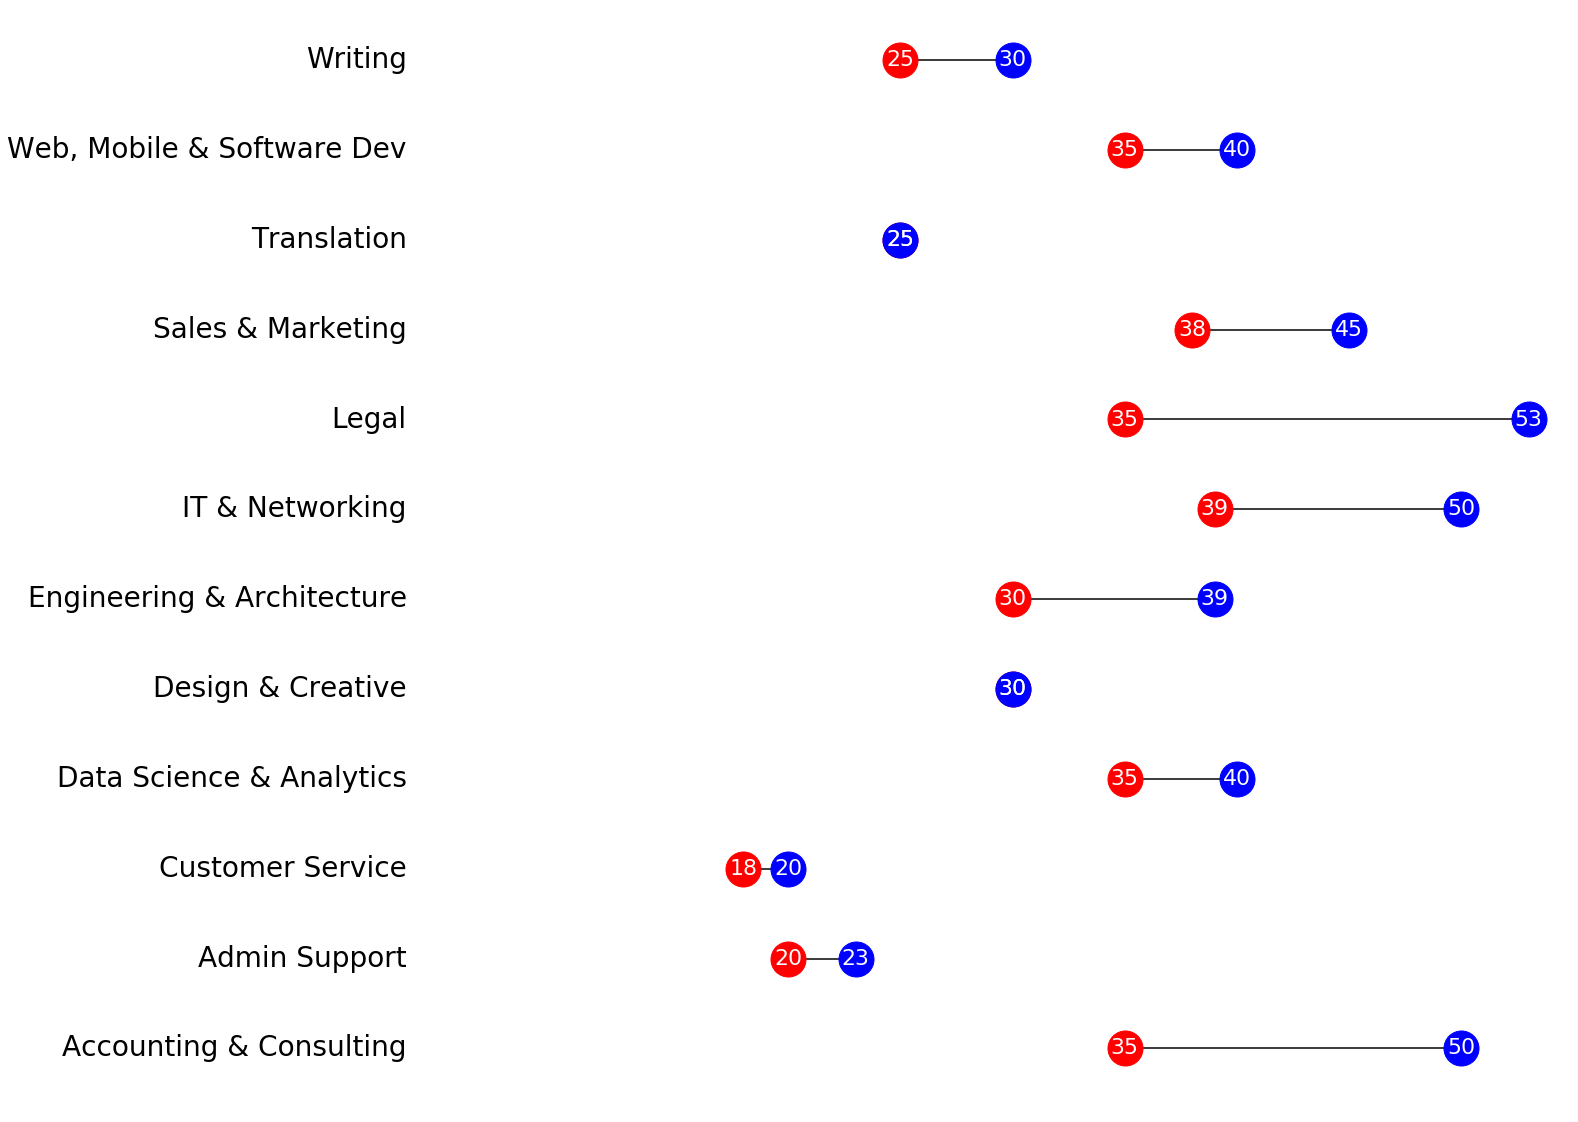

In [63]:

labels = ["Accounting & Consulting", "Admin Support", "Customer Service", "Data Science & Analytics",
                      "Design & Creative", "Engineering & Architecture", "IT & Networking", 
                      "Legal", "Sales & Marketing", "Translation", "Web, Mobile & Software Dev", 
                      "Writing"]
a_values = female_rates
b_values = male_rates

# Create the figure
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111)

for i in list(range(len(labels))):
    # Plot the line between dumbbells
    ax.plot([a_values[i], b_values[i]], [i, i], color='black')
    # Plot the dumbbells.
    ax.plot(a_values[i], i, color='red', marker='o', markersize=35)
    ax.plot(b_values[i], i, color='blue', marker='o', markersize=35)
    # Add data label on top of dumbbells
    ax.text(a_values[i], i, a_values[i], horizontalalignment='center', verticalalignment='center', color='white', fontsize=22)
    ax.text(b_values[i], i, b_values[i], horizontalalignment='center', verticalalignment='center', color='white', fontsize=22)
    # Add the axis label
    ax.text(3, i, labels[i], horizontalalignment='right', verticalalignment='center', fontsize=28)

# Adjust and show the plot
fig.subplots_adjust(left=0.3)
ax.set_axis_off()
plt.show()

## Comparing age ranges across our final and BLS dataset

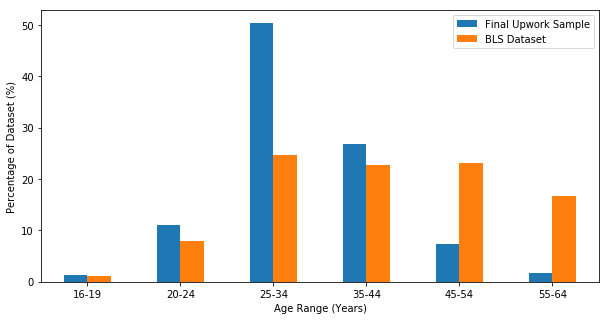

In [4]:
index = ["16-19", "20-24", "25-34", "35-44", "45-54", "55-64"]
columns = ['Final Upwork Sample', 'BLS Dataset']

final_age_percentages = [1.41, 11.06, 50.41, 26.83, 7.40, 1.77, 1.11]
bls_age_percentages = [1.16, 7.91, 24.71, 22.76, 23.10, 16.65, 3.72]

bls_age_comparison_df = pd.DataFrame(index=index, columns=columns)

current_index = 0
for index, row in bls_age_comparison_df.iterrows():
    row['Final Upwork Sample'] = final_age_percentages[current_index]
    row['BLS Dataset'] = bls_age_percentages[current_index]
    current_index += 1

graph = bls_age_comparison_df.plot(kind="bar", figsize=(10,5))
plt.xticks(rotation='horizontal')
graph.set_xlabel("Age Range (Years)")
graph.set_ylabel("Percentage of Dataset (%)")


## Comparing Education Level Across Samples

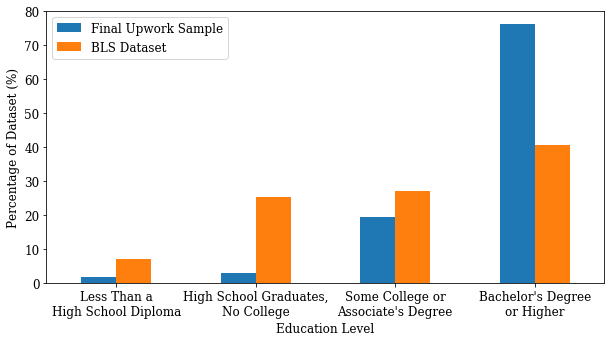

In [47]:
index = ["Less Than a\nHigh School Diploma", "High School Graduates,\nNo College", 
         "Some College or\nAssociate's Degree", "Bachelor's Degree\nor Higher"]
columns = ['Final Upwork Sample', 'BLS Dataset']

final_percentages = [1.58, 2.79, 19.37, 76.26]
bls_percentages = [7.04, 25.22, 27.03, 40.71]

bls_comparison_df = pd.DataFrame(index=index, columns=columns)

current_index = 0
for index, row in bls_comparison_df.iterrows():
    row['Final Upwork Sample'] = final_percentages[current_index]
    row['BLS Dataset'] = bls_percentages[current_index]
    current_index += 1

plt.rcParams.update({'font.size': 12})
graph = bls_comparison_df.plot(kind="bar", figsize=(10,5))
plt.xticks(rotation='horizontal')
graph.set_xlabel("Education Level")
graph.set_ylabel("Percentage of Dataset (%)")



## Making pay equal across categories

In [6]:
job_categories_list = ["Accounting & Consulting", "Admin Support", "Customer Service", "Data Science & Analytics",
                      "Design & Creative", "Engineering & Architecture", "IT & Networking", 
                      "Legal", "Sales & Marketing", "Translation", "Web, Mobile & Software Dev", 
                      "Writing"]

pay_dict = defaultdict(list)


def equalize_within_category():
    for job in job_categories_list:
        # Calculate female earnings
        df_female = merged[(merged['job_category'] == job) & (merged['gender_computer'] == "female")]
        female_mean = np.mean(df_female['bill_rate'])
        female_median = np.median(df_female['bill_rate'])
        
        # Calculate male earnings
        df_male = merged[(merged['job_category'] == job) & (merged['gender_computer'] == "male")]
        male_mean = np.mean(df_male['bill_rate'])
        male_median = np.median(df_male['bill_rate'])
        
        # Calculate weights
        female_weight = len(df_female.index)
        male_weight = len(df_male.index)
        
        pay_dict[job].append(female_mean)
        pay_dict[job].append(female_weight)
        pay_dict[job].append(male_mean)
        pay_dict[job].append(male_weight)
        

equalize_within_category()

# Assuming pay is equal within categories
def make_equal_pay_female(row):
    job = row['job_category']
    return pay_dict[job][0]

def make_equal_pay_male(row):
    job = row['job_category']
    return pay_dict[job][2]

merged['equal_pay_female'] = merged.apply(make_equal_pay_female, axis=1)
merged['equal_pay_male'] = merged.apply(make_equal_pay_male, axis=1)

# Assuming proportions are equal within categories
# Calculate appropriate weight for each row in the dataset

female_weights = []
male_weights = []



for category in pay_dict:
    female_count = int(pay_dict[category][1])
    male_count = int(pay_dict[category][3])
    
    # Using female weights
    female_weight = float(female_count)/float(male_count)
    
    # Using male weights
    male_weight = float(male_count)/float(female_count)
    
    pay_dict[category].append(female_weight)
    pay_dict[category].append(male_weight)

print (pay_dict)

for index, row in merged.iterrows():
    job = row['job_category']
    if row['gender_computer'] == "female":
        female_weights.append(1)
        male_weights.append(pay_dict[job][5])
    elif row['gender_computer'] == "male":
        female_weights.append(pay_dict[job][4])
        male_weights.append(1)

print (female_weights)
print (male_weights)
    

defaultdict(<type 'list'>, {'Web, Mobile & Software Dev': [41.87363636363637, 1287, 48.71858350174533, 5443, 0.23645048686386183, 4.229215229215229], 'Customer Service': [21.890709592641265, 761, 31.514832535885162, 418, 1.8205741626794258, 0.5492772667542707], 'IT & Networking': [49.48882882882883, 222, 61.177267709291606, 1087, 0.20423183072677092, 4.896396396396397], 'Legal': [51.03327272727273, 220, 86.64653846153846, 156, 1.4102564102564104, 0.7090909090909091], 'Writing': [33.70522967663948, 6618, 39.056072022160684, 3610, 1.8332409972299168, 0.5454820187367785], 'Data Science & Analytics': [42.42749440715884, 447, 49.956150761828376, 1247, 0.35846030473135526, 2.7897091722595078], 'Design & Creative': [38.94083333333332, 5016, 41.71691153238547, 6330, 0.7924170616113744, 1.2619617224880382], 'Accounting & Consulting': [50.9356976744186, 1290, 69.67336041358938, 1354, 0.9527326440177253, 1.0496124031007752], 'Admin Support': [24.74971523178808, 4530, 28.64726283048212, 1286, 3.52

In [11]:
## Run OLS regressions, equalizing for pay and weights

merged['log_equal_female_pay'] = merged['equal_pay_female'].apply(math.log10)
merged['log_equal_male_pay'] = merged['equal_pay_male'].apply(math.log10)

print (np.mean(merged[merged['gender_computer'] == "female"]['equal_pay_female']))
print (np.mean(merged[merged['gender_computer'] == "male"]['equal_pay_female']))

print (np.mean(merged[merged['gender_computer'] == "female"]['equal_pay_male']))
print (np.mean(merged[merged['gender_computer'] == "male"]['equal_pay_male']))

model = ols("log_equal_female_pay ~ dummy_gender", merged).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(model.summary())
print (anova_table)

print (model.params)


35.6069545183
39.8287776627
41.5853447752
46.350076075
                             OLS Regression Results                             
Dep. Variable:     log_equal_female_pay   R-squared:                       0.077
Model:                              OLS   Adj. R-squared:                  0.077
Method:                   Least Squares   F-statistic:                     4024.
Date:                  Fri, 23 Mar 2018   Prob (F-statistic):               0.00
Time:                          15:16:26   Log-Likelihood:                 46018.
No. Observations:                 48019   AIC:                        -9.203e+04
Df Residuals:                     48017   BIC:                        -9.202e+04
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

In [100]:
model = ols("log_equal_male_pay ~ dummy_gender", merged).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(model.summary())
print (anova_table)

print (model.params)

                            OLS Regression Results                            
Dep. Variable:     log_equal_male_pay   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     3085.
Date:                Thu, 15 Mar 2018   Prob (F-statistic):               0.00
Time:                        10:58:07   Log-Likelihood:                 41033.
No. Observations:               48019   AIC:                        -8.206e+04
Df Residuals:                   48017   BIC:                        -8.204e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.6038      0.001   2384.792   

In [24]:
from __future__ import print_function
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.iolib.table import (SimpleTable, default_txt_fmt)

def log_this(row):
    return math.log10(row['bill_rate'])

merged['log_bill_rate'] = merged.apply(log_this, axis=1) # Convert to log of hourly bill rates

bill_array = []
gender_array = []
for i in merged.log_bill_rate:
    bill_array.append(i)
    
for i in merged.dummy_gender:
    gender_array.append(i)
    
mod_wls = sm.WLS(bill_array, gender_array, weights=female_weights)
res_wls = mod_wls.fit()
print(res_wls.summary())

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.524
Model:                            WLS   Adj. R-squared:                  0.524
Method:                 Least Squares   F-statistic:                 5.287e+04
Date:                Fri, 23 Mar 2018   Prob (F-statistic):               0.00
Time:                        15:39:05   Log-Likelihood:                -70861.
No. Observations:               48019   AIC:                         1.417e+05
Df Residuals:                   48018   BIC:                         1.417e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.5523      0.007    229.944      0.0

In [25]:
model = ols("log_bill_rate ~ dummy_gender", merged).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(model.summary())
print (anova_table)

print (model.params)

                            OLS Regression Results                            
Dep. Variable:          log_bill_rate   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     1304.
Date:                Fri, 23 Mar 2018   Prob (F-statistic):          1.17e-281
Time:                        15:39:08   Log-Likelihood:                -9214.4
No. Observations:               48019   AIC:                         1.843e+04
Df Residuals:                   48017   BIC:                         1.845e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.4557      0.002    760.172   

In [102]:
mod_wls = sm.WLS(merged.log_bill_rate, merged.dummy_gender, weights=male_weights)
res_wls = mod_wls.fit()
print(res_wls.summary())

                            WLS Regression Results                            
Dep. Variable:          log_bill_rate   R-squared:                       0.497
Model:                            WLS   Adj. R-squared:                  0.497
Method:                 Least Squares   F-statistic:                 4.750e+04
Date:                Thu, 15 Mar 2018   Prob (F-statistic):               0.00
Time:                        10:58:16   Log-Likelihood:                -76618.
No. Observations:               48019   AIC:                         1.532e+05
Df Residuals:                   48018   BIC:                         1.532e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
dummy_gender     1.5523      0.007    217.945   

In [103]:
mod_wls = sm.WLS(merged.log_equal_female_pay, merged.dummy_gender)
res_wls = mod_wls.fit()
print(res_wls.summary())

                             WLS Regression Results                             
Dep. Variable:     log_equal_female_pay   R-squared:                       0.527
Model:                              WLS   Adj. R-squared:                  0.527
Method:                   Least Squares   F-statistic:                 5.354e+04
Date:                  Thu, 15 Mar 2018   Prob (F-statistic):               0.00
Time:                          10:58:17   Log-Likelihood:                -71809.
No. Observations:                 48019   AIC:                         1.436e+05
Df Residuals:                     48018   BIC:                         1.436e+05
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
dummy_gender     1.5931     

In [104]:
mod_wls = sm.WLS(merged.log_equal_male_pay, merged.dummy_gender)
res_wls = mod_wls.fit()
print(res_wls.summary())

                            WLS Regression Results                            
Dep. Variable:     log_equal_male_pay   R-squared:                       0.526
Model:                            WLS   Adj. R-squared:                  0.526
Method:                 Least Squares   F-statistic:                 5.324e+04
Date:                Thu, 15 Mar 2018   Prob (F-statistic):               0.00
Time:                        10:58:21   Log-Likelihood:                -73801.
No. Observations:               48019   AIC:                         1.476e+05
Df Residuals:                   48018   BIC:                         1.476e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
dummy_gender     1.6560      0.007    230.742   

In [106]:
mod_wls = sm.WLS(merged.log_bill_rate, merged.dummy_gender, weights=male_weights)
res_wls = mod_wls.fit()
print(res_wls.summary())

                            WLS Regression Results                            
Dep. Variable:          log_bill_rate   R-squared:                       0.497
Model:                            WLS   Adj. R-squared:                  0.497
Method:                 Least Squares   F-statistic:                 4.750e+04
Date:                Thu, 15 Mar 2018   Prob (F-statistic):               0.00
Time:                        10:58:24   Log-Likelihood:                -76618.
No. Observations:               48019   AIC:                         1.532e+05
Df Residuals:                   48018   BIC:                         1.532e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
dummy_gender     1.5523      0.007    217.945   

In [107]:
mod_wls = sm.WLS(merged.log_bill_rate, merged.dummy_gender)
res_wls = mod_wls.fit()
print(res_wls.summary())

                            WLS Regression Results                            
Dep. Variable:          log_bill_rate   R-squared:                       0.524
Model:                            WLS   Adj. R-squared:                  0.524
Method:                 Least Squares   F-statistic:                 5.287e+04
Date:                Thu, 15 Mar 2018   Prob (F-statistic):               0.00
Time:                        10:58:25   Log-Likelihood:                -70861.
No. Observations:               48019   AIC:                         1.417e+05
Df Residuals:                   48018   BIC:                         1.417e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
dummy_gender     1.5523      0.007    229.944   

## Gender Pay Gap within Job Categories

Following Goldin's argument that the majority of the pay gap can be explained by within job gender differences in pay. 

In [108]:
merged['hours_worked'] == merged['hours_worked'].astype('float')

def log_this(row):
    return math.log10(row['bill_rate'])

merged['log_bill_rate'] = merged.apply(log_this, axis=1) # Convert to log of hourly bill rates

model = ols("log_bill_rate ~ gender_computer", merged).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(model.summary())
print (anova_table)

print (model.params)

                            OLS Regression Results                            
Dep. Variable:          log_bill_rate   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     1304.
Date:                Thu, 15 Mar 2018   Prob (F-statistic):          1.17e-281
Time:                        10:58:34   Log-Likelihood:                -9214.4
No. Observations:               48019   AIC:                         1.843e+04
Df Residuals:                   48017   BIC:                         1.845e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [109]:
model = ols("log_bill_rate ~ gender_computer + hours_worked", merged).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print (model.summary())
print (anova_table)

print (model.params)

                            OLS Regression Results                            
Dep. Variable:          log_bill_rate   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     654.3
Date:                Thu, 15 Mar 2018   Prob (F-statistic):          4.26e-281
Time:                        10:58:41   Log-Likelihood:                -9211.9
No. Observations:               48019   AIC:                         1.843e+04
Df Residuals:                   48016   BIC:                         1.846e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [110]:
model = ols("log_bill_rate ~ gender_computer + hours_worked + education", merged).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(model.summary())
print (anova_table)

print (model.params)

                            OLS Regression Results                            
Dep. Variable:          log_bill_rate   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     524.0
Date:                Thu, 15 Mar 2018   Prob (F-statistic):               0.00
Time:                        10:58:46   Log-Likelihood:                -8581.9
No. Observations:               48019   AIC:                         1.718e+04
Df Residuals:                   48013   BIC:                         1.723e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

In [111]:
model = ols("log_bill_rate ~ gender_computer + hours_worked + education + job_category", merged).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(model.summary())
print (anova_table)

print (model.params)

                            OLS Regression Results                            
Dep. Variable:          log_bill_rate   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     462.3
Date:                Thu, 15 Mar 2018   Prob (F-statistic):               0.00
Time:                        10:58:52   Log-Likelihood:                -6416.9
No. Observations:               48019   AIC:                         1.287e+04
Df Residuals:                   48002   BIC:                         1.302e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

### Even when using number of jobs completed as a proxy for work experience, pay gap is not explained any better

In [112]:
model = ols("log_bill_rate ~ gender_computer + jobs_completed", merged).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(model.summary())
print (anova_table)

print (model.params)

                            OLS Regression Results                            
Dep. Variable:          log_bill_rate   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     677.0
Date:                Thu, 15 Mar 2018   Prob (F-statistic):          1.07e-290
Time:                        10:58:59   Log-Likelihood:                -9189.8
No. Observations:               48019   AIC:                         1.839e+04
Df Residuals:                   48016   BIC:                         1.841e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [113]:
model = ols("log_bill_rate ~ gender_computer + jobs_completed + education", merged).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(model.summary())
print (anova_table)

print (model.params)

                            OLS Regression Results                            
Dep. Variable:          log_bill_rate   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     533.4
Date:                Thu, 15 Mar 2018   Prob (F-statistic):               0.00
Time:                        10:59:05   Log-Likelihood:                -8559.5
No. Observations:               48019   AIC:                         1.713e+04
Df Residuals:                   48013   BIC:                         1.718e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

In [114]:
model = ols("log_bill_rate ~ gender_computer + jobs_completed + education + job_category", merged).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(model.summary())
print (anova_table)

print (model.params)

                            OLS Regression Results                            
Dep. Variable:          log_bill_rate   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     466.7
Date:                Thu, 15 Mar 2018   Prob (F-statistic):               0.00
Time:                        10:59:13   Log-Likelihood:                -6386.4
No. Observations:               48019   AIC:                         1.281e+04
Df Residuals:                   48002   BIC:                         1.296e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

### Using work experience in years a proxy for work experience

In [115]:
model = ols("log_bill_rate ~ gender_computer + work_experience", merged).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(model.summary())
print (anova_table)

print (model.params)

                            OLS Regression Results                            
Dep. Variable:          log_bill_rate   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     1618.
Date:                Thu, 15 Mar 2018   Prob (F-statistic):               0.00
Time:                        10:59:19   Log-Likelihood:                -8292.0
No. Observations:               48019   AIC:                         1.659e+04
Df Residuals:                   48016   BIC:                         1.662e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [116]:
model = ols("log_bill_rate ~ gender_computer + work_experience + education", merged).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(model.summary())
print (anova_table)

print (model.params)

                            OLS Regression Results                            
Dep. Variable:          log_bill_rate   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     906.8
Date:                Thu, 15 Mar 2018   Prob (F-statistic):               0.00
Time:                        10:59:24   Log-Likelihood:                -7690.9
No. Observations:               48019   AIC:                         1.539e+04
Df Residuals:                   48013   BIC:                         1.545e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

In [117]:
model = ols("log_bill_rate ~ gender_computer + work_experience + education + job_category", merged).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(model.summary())
print (anova_table)

print (model.params)

                            OLS Regression Results                            
Dep. Variable:          log_bill_rate   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     610.8
Date:                Thu, 15 Mar 2018   Prob (F-statistic):               0.00
Time:                        10:59:30   Log-Likelihood:                -5408.2
No. Observations:               48019   AIC:                         1.085e+04
Df Residuals:                   48002   BIC:                         1.100e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

### When all covariates are added, gender pay gap is not explained better

In [118]:
model = ols("log_bill_rate ~ gender_computer + jobs_completed + work_experience + hours_worked + job_category + education", merged).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(model.summary())
print (anova_table)

print (model.params)

                            OLS Regression Results                            
Dep. Variable:          log_bill_rate   R-squared:                       0.170
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     545.2
Date:                Thu, 15 Mar 2018   Prob (F-statistic):               0.00
Time:                        10:59:42   Log-Likelihood:                -5391.1
No. Observations:               48019   AIC:                         1.082e+04
Df Residuals:                   48000   BIC:                         1.099e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

### Same analyses, but only including workers with at least some work experience on Upwork

In [119]:
merged_have_worked = merged[merged['hours_worked'] > 0]

model = ols("log_bill_rate ~ gender_computer", merged_have_worked).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(model.summary())
print (anova_table)

print (model.params)

                            OLS Regression Results                            
Dep. Variable:          log_bill_rate   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     526.6
Date:                Thu, 15 Mar 2018   Prob (F-statistic):          1.53e-113
Time:                        10:59:48   Log-Likelihood:                -1280.0
No. Observations:                9747   AIC:                             2564.
Df Residuals:                    9745   BIC:                             2578.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [120]:
model = ols("log_bill_rate ~ gender_computer + hours_worked", merged_have_worked).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(model.summary())
print (anova_table)

print (model.params)

                            OLS Regression Results                            
Dep. Variable:          log_bill_rate   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     271.7
Date:                Thu, 15 Mar 2018   Prob (F-statistic):          1.55e-115
Time:                        10:59:53   Log-Likelihood:                -1272.0
No. Observations:                9747   AIC:                             2550.
Df Residuals:                    9744   BIC:                             2572.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [121]:
model = ols("log_bill_rate ~ gender_computer + hours_worked + education", merged_have_worked).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(model.summary())
print (anova_table)

print (model.params)

                            OLS Regression Results                            
Dep. Variable:          log_bill_rate   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     147.3
Date:                Thu, 15 Mar 2018   Prob (F-statistic):          3.37e-151
Time:                        10:59:58   Log-Likelihood:                -1181.3
No. Observations:                9747   AIC:                             2375.
Df Residuals:                    9741   BIC:                             2418.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

In [122]:
model = ols("log_bill_rate ~ gender_computer + hours_worked + education + job_category", merged_have_worked).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(model.summary())
print (anova_table)

print (model.params)

                            OLS Regression Results                            
Dep. Variable:          log_bill_rate   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.154
Method:                 Least Squares   F-statistic:                     111.8
Date:                Thu, 15 Mar 2018   Prob (F-statistic):               0.00
Time:                        11:00:03   Log-Likelihood:                -713.75
No. Observations:                9747   AIC:                             1461.
Df Residuals:                    9730   BIC:                             1584.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

### Using number of jobs worked as a proxy for time working

In [123]:
model = ols("log_bill_rate ~ gender_computer + jobs_completed", merged_have_worked).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(model.summary())
print (anova_table)

print (model.params)

                            OLS Regression Results                            
Dep. Variable:          log_bill_rate   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     282.7
Date:                Thu, 15 Mar 2018   Prob (F-statistic):          4.40e-120
Time:                        11:00:09   Log-Likelihood:                -1261.5
No. Observations:                9747   AIC:                             2529.
Df Residuals:                    9744   BIC:                             2551.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

### Using work experience as a proxy for time working

In [124]:
model = ols("log_bill_rate ~ gender_computer + work_experience", merged_have_worked).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(model.summary())
print (anova_table)

print (model.params)

                            OLS Regression Results                            
Dep. Variable:          log_bill_rate   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     411.8
Date:                Thu, 15 Mar 2018   Prob (F-statistic):          2.13e-172
Time:                        11:00:14   Log-Likelihood:                -1141.1
No. Observations:                9747   AIC:                             2288.
Df Residuals:                    9744   BIC:                             2310.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [125]:
model = ols("log_bill_rate ~ gender_computer + work_experience + education", merged_have_worked).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(model.summary())
print (anova_table)

print (model.params)

                            OLS Regression Results                            
Dep. Variable:          log_bill_rate   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     207.4
Date:                Thu, 15 Mar 2018   Prob (F-statistic):          8.20e-211
Time:                        11:00:20   Log-Likelihood:                -1043.5
No. Observations:                9747   AIC:                             2099.
Df Residuals:                    9741   BIC:                             2142.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

In [126]:
model = ols("log_bill_rate ~ gender_computer + work_experience + education + job_category", merged_have_worked).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(model.summary())
print (anova_table)

print (model.params)

                            OLS Regression Results                            
Dep. Variable:          log_bill_rate   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.181
Method:                 Least Squares   F-statistic:                     135.2
Date:                Thu, 15 Mar 2018   Prob (F-statistic):               0.00
Time:                        11:00:25   Log-Likelihood:                -557.88
No. Observations:                9747   AIC:                             1150.
Df Residuals:                    9730   BIC:                             1272.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

### Only including workers who have completed at least 1 job

In [127]:
merged_one_job = merged[merged['jobs_completed'] > 0]

model = ols("log_bill_rate ~ gender_computer", merged_one_job).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(model.summary())
print (anova_table)

print (model.params)

                            OLS Regression Results                            
Dep. Variable:          log_bill_rate   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     582.6
Date:                Thu, 15 Mar 2018   Prob (F-statistic):          3.82e-126
Time:                        11:00:31   Log-Likelihood:                -2099.7
No. Observations:               13987   AIC:                             4203.
Df Residuals:                   13985   BIC:                             4219.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [128]:
model = ols("log_bill_rate ~ gender_computer + hours_worked", merged_one_job).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(model.summary())
print (anova_table)

print (model.params)

                            OLS Regression Results                            
Dep. Variable:          log_bill_rate   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     297.9
Date:                Thu, 15 Mar 2018   Prob (F-statistic):          2.09e-127
Time:                        11:00:35   Log-Likelihood:                -2093.4
No. Observations:               13987   AIC:                             4193.
Df Residuals:                   13984   BIC:                             4215.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [129]:
model = ols("log_bill_rate ~ gender_computer + jobs_completed", merged_one_job).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(model.summary())
print (anova_table)

print (model.params)

                            OLS Regression Results                            
Dep. Variable:          log_bill_rate   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     310.6
Date:                Thu, 15 Mar 2018   Prob (F-statistic):          1.02e-132
Time:                        11:00:39   Log-Likelihood:                -2081.2
No. Observations:               13987   AIC:                             4168.
Df Residuals:                   13984   BIC:                             4191.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [130]:
model = ols("log_bill_rate ~ gender_computer + work_experience", merged_one_job).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(model.summary())
print (anova_table)

print (model.params)

                            OLS Regression Results                            
Dep. Variable:          log_bill_rate   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     510.5
Date:                Thu, 15 Mar 2018   Prob (F-statistic):          1.01e-214
Time:                        11:00:43   Log-Likelihood:                -1892.3
No. Observations:               13987   AIC:                             3791.
Df Residuals:                   13984   BIC:                             3813.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

## Across different job categories, what is the relationship between hours worked and hourly bill rate?

,bill_rate,hours_worked
bill_rate,1.00000,-0.06768
hours_worked,-0.06768,1.00000


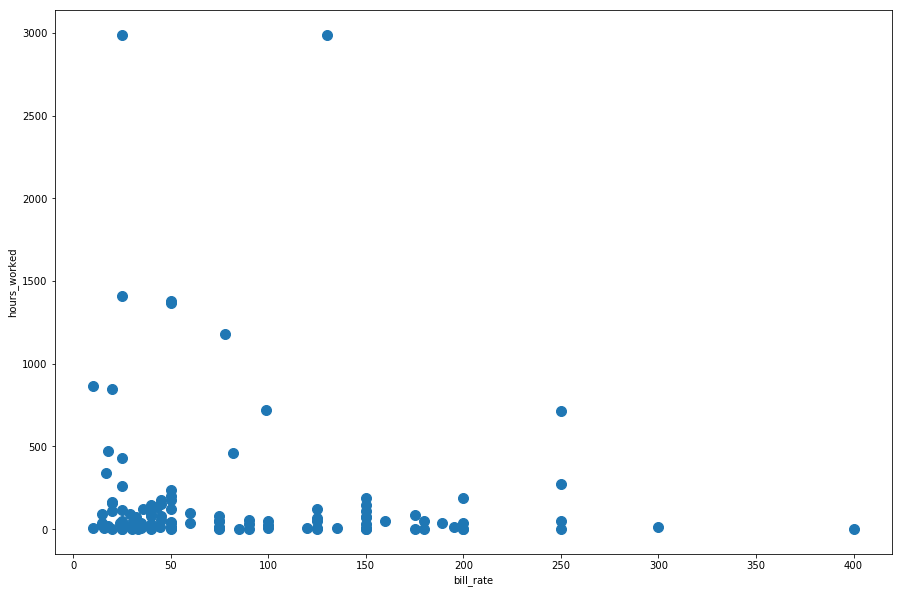

In [42]:
# Change this into a function 
merged_legal = merged[(merged['job_category'] == 'Legal') & (merged['hours_worked'] > 0)]

merged_legal

merged_legal.plot(kind='scatter', x='bill_rate', y='hours_worked', figsize=(15, 10), s=100)

merged_legal_df = merged_legal[['bill_rate', 'hours_worked']]
merged_legal_df.corr(method='pearson')

,bill_rate,hours_worked
bill_rate,1.000000,0.014128
hours_worked,0.014128,1.000000


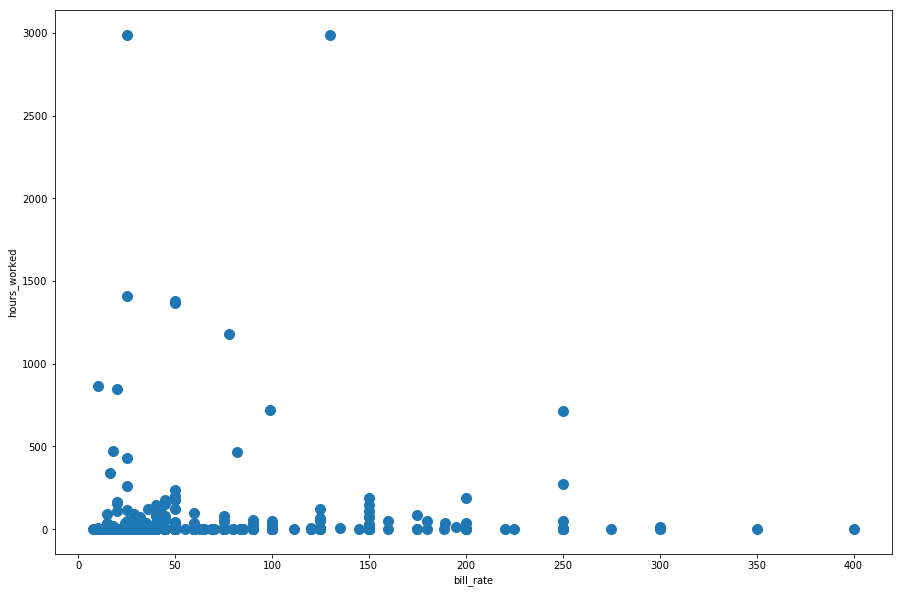

In [43]:
# Change this into a function 
merged_legal = merged[(merged['job_category'] == 'Legal')]

merged_legal

merged_legal.plot(kind='scatter', x='bill_rate', y='hours_worked', figsize=(15, 10), s=100)

merged_legal_df = merged_legal[['bill_rate', 'hours_worked']]
merged_legal_df.corr(method='pearson')

,bill_rate,work_experience
bill_rate,1.000000,0.293943
work_experience,0.293943,1.000000


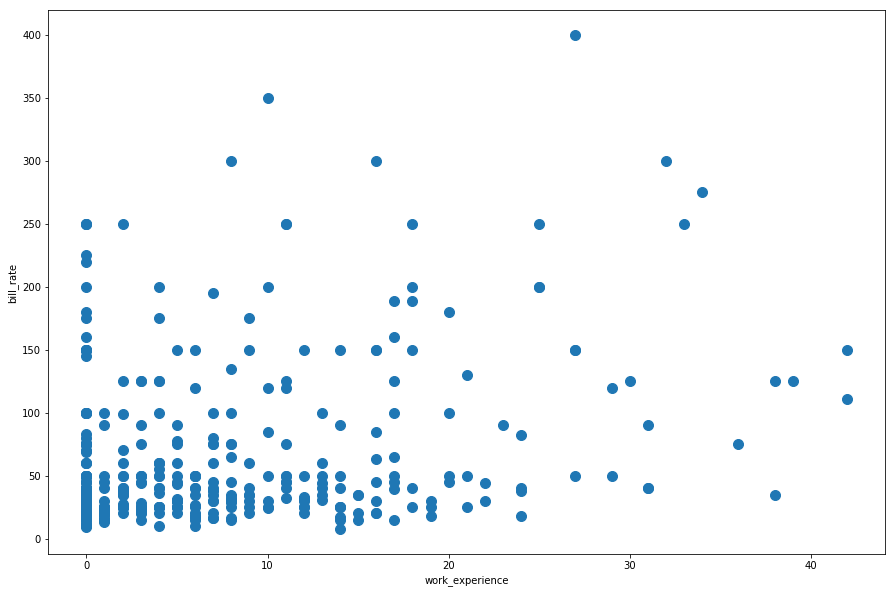

In [44]:
# Change this into a function 
merged_legal = merged[(merged['job_category'] == 'Legal')]

merged_legal

merged_legal.plot(kind='scatter', x='work_experience', y='bill_rate', figsize=(15, 10), s=100)

merged_legal_df = merged_legal[['bill_rate', 'work_experience']]
merged_legal_df.corr(method='pearson')

,bill_rate,hours_worked
bill_rate,1.00000,-0.05157
hours_worked,-0.05157,1.00000


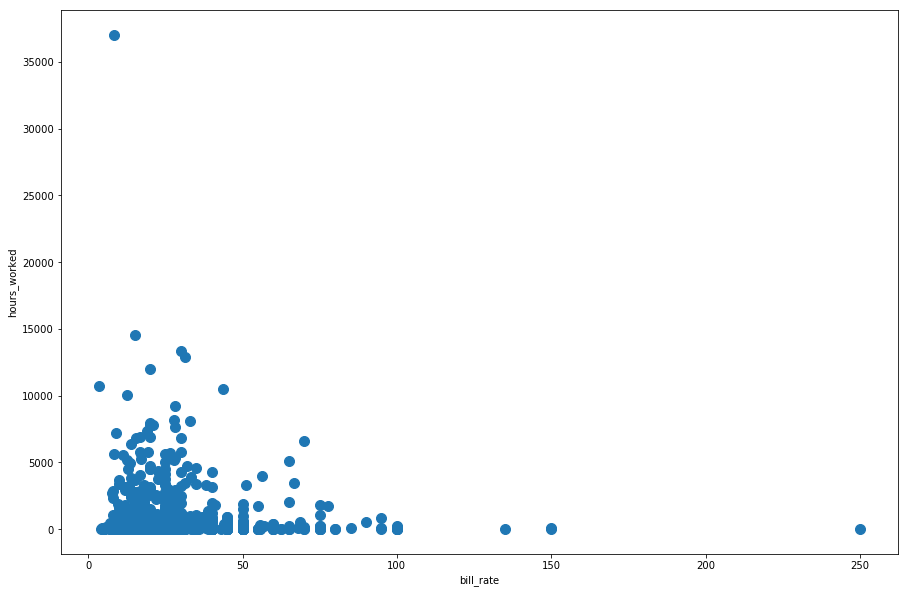

In [45]:
merged_admin = merged[(merged['job_category'] == 'Admin Support') & (merged['hours_worked'] > 0)]

merged_admin

merged_admin.plot(kind='scatter', x='bill_rate', y='hours_worked', figsize=(15, 10), s=100)

merged_admin_df = merged_admin[['bill_rate', 'hours_worked']]
merged_admin_df.corr(method='pearson')

,bill_rate,work_experience
bill_rate,1.000000,0.102725
work_experience,0.102725,1.000000


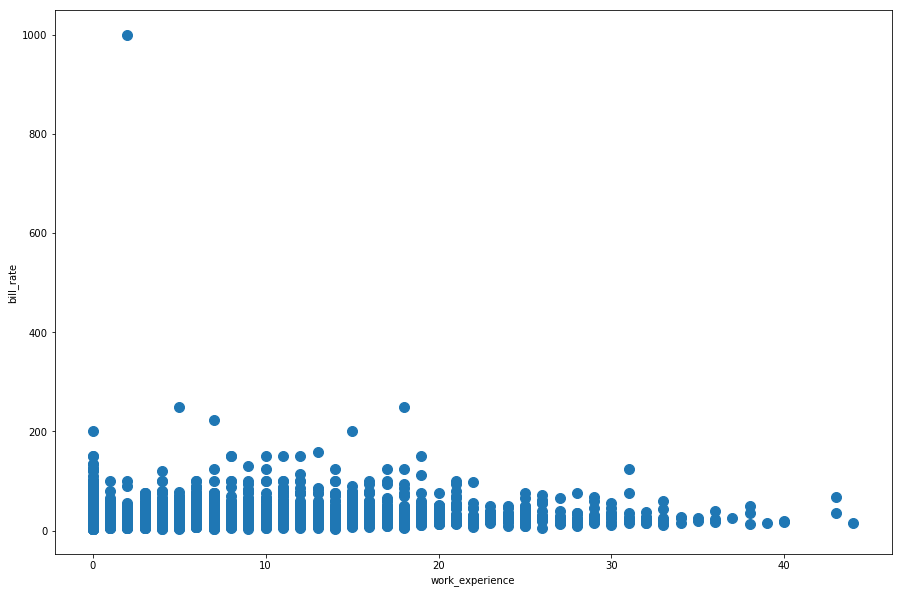

In [46]:
merged_admin = merged[(merged['job_category'] == 'Admin Support')]

merged_admin

merged_admin.plot(kind='scatter', x='work_experience', y='bill_rate', figsize=(15, 10), s=100)

merged_admin_df = merged_admin[['bill_rate', 'work_experience']]
merged_admin_df.corr(method='pearson')

,bill_rate,hours_worked
bill_rate,1.000000,0.003385
hours_worked,0.003385,1.000000


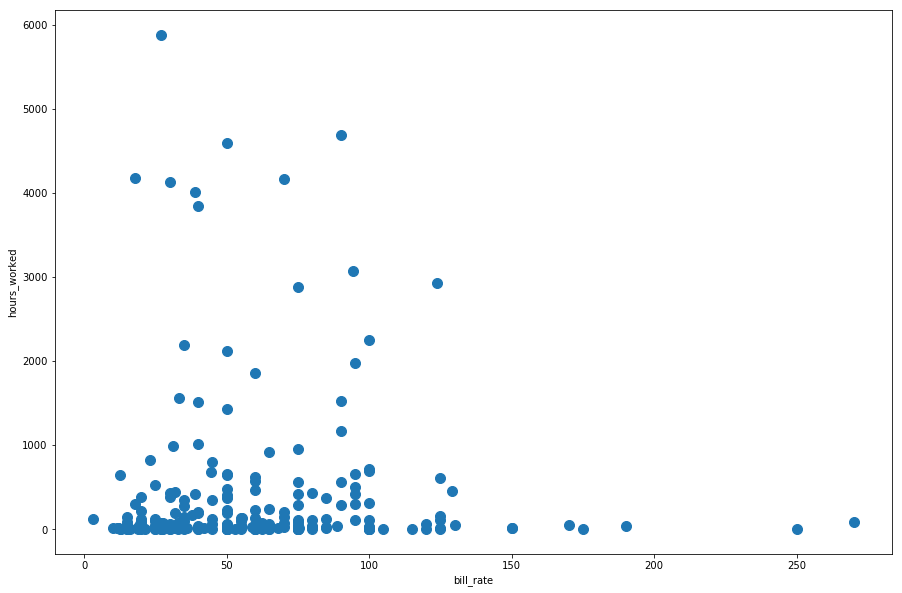

In [47]:
merged_it = merged[(merged['job_category'] == 'IT & Networking') & (merged['hours_worked'] > 0)]

merged_it

merged_it.plot(kind='scatter', x='bill_rate', y='hours_worked', figsize=(15, 10), s=100)

merged_it_df = merged_it[['bill_rate', 'hours_worked']]
merged_it_df.corr(method='pearson')

,bill_rate,work_experience
bill_rate,1.000000,0.072297
work_experience,0.072297,1.000000


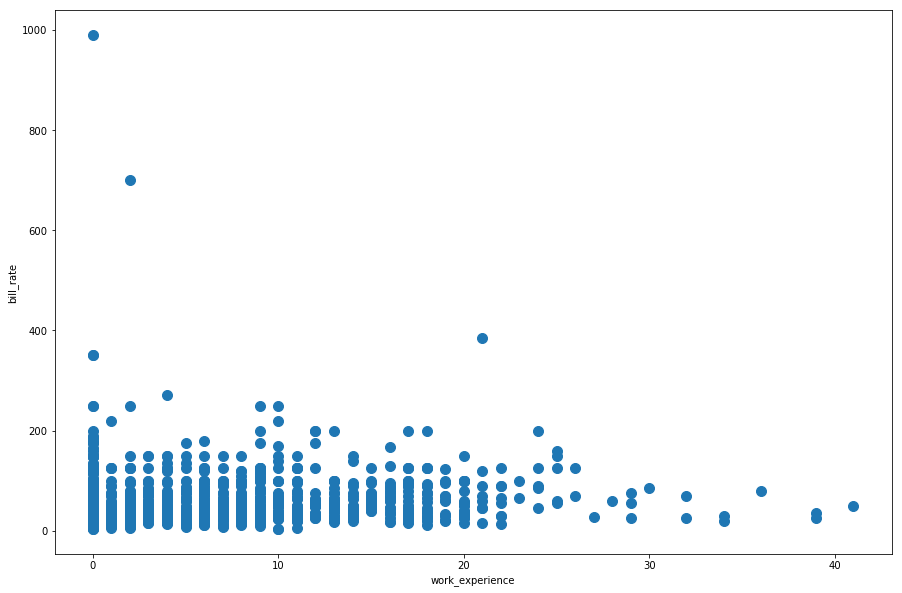

In [48]:
merged_it = merged[(merged['job_category'] == 'IT & Networking')]

merged_it

merged_it.plot(kind='scatter', x='work_experience', y='bill_rate', figsize=(15, 10), s=100)

merged_it_df = merged_it[['bill_rate', 'work_experience']]
merged_it_df.corr(method='pearson')

,bill_rate,hours_worked
bill_rate,1.000000,0.036127
hours_worked,0.036127,1.000000


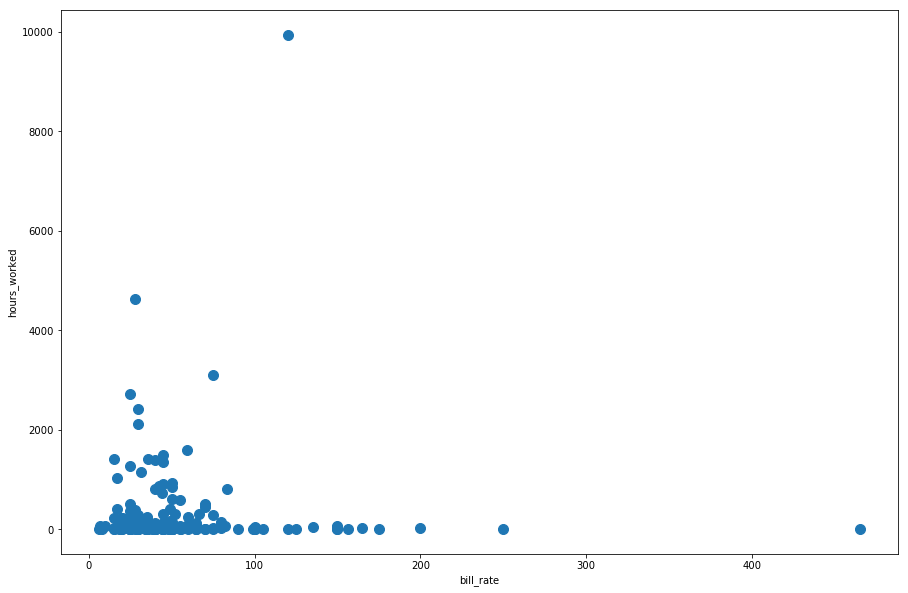

In [49]:
merged_eng = merged[(merged['job_category'] == 'Engineering & Architecture') & (merged['hours_worked'] > 0)]

merged_eng

merged_eng.plot(kind='scatter', x='bill_rate', y='hours_worked', figsize=(15, 10), s=100)

merged_eng_df = merged_eng[['bill_rate', 'hours_worked']]
merged_eng_df.corr(method='pearson')

## Cross-correlation Matrix of Covariates

(I realized I can't do this because some of these are categorical variables)

In [50]:
cross_correlation_df = merged[['job_category', 'work_experience', 'education', 'new_age_range_id', 'final_gender']]

cross_correlation_df.corr()

,work_experience
work_experience,1.0


## Distribution of Education Levels

In [52]:
edu_table= merged.groupby('education').count()
print (edu_table)

                           Unnamed: 0  user_count  worker_id_x  bill_rate  \
education                                                                   
Bachelor or Higher              36519       36519        36519      36519   
High School                      1360        1360         1360       1360   
Less Than High School             766         766          766        766   
Some College or Associate        9374        9374         9374       9374   

                           job_category  job_category_id  jobs_completed  \
education                                                                  
Bachelor or Higher                36519            36519           36519   
High School                        1360             1360            1360   
Less Than High School               766              766             766   
Some College or Associate          9374             9374            9374   

                           profile_desc_x  hours_worked  feedback_score  \
educa

## Regressions Showing Influence of Job Category on Pay Gap

These are regressions on the log of the hourly bill rates so that we can interpret the coefficients as percentage changes. 

In [8]:
print merged[merged['gender_computer'] == 'female'].describe()

print merged[merged['gender_computer'] == 'male'].describe()

print merged.describe()

         Unnamed: 0    user_count     bill_rate  job_category_id  \
count  23438.000000  23438.000000  23438.000000     23438.000000   
mean   28295.039295  28296.039295     35.606955         6.176082   
std    15837.271306  15837.271306     31.768562         3.655297   
min        0.000000      1.000000      3.000000         0.000000   
25%    14729.500000  14730.500000     20.000000         3.000000   
50%    29037.500000  29038.500000     26.000000         7.000000   
75%    41486.750000  41487.750000     40.000000         9.000000   
max    55515.000000  55516.000000    999.000000        12.000000   

       jobs_completed  hours_worked  feedback_score    no_reviews  \
count    23438.000000  23438.000000    23438.000000  23438.000000   
mean         5.843459     95.381427        1.123837      3.691569   
std         32.807977    645.410167        2.054016     20.186435   
min          0.000000      0.000000        0.000000      0.000000   
25%          0.000000      0.000000       

In [9]:
def log_this(row):
    return math.log10(row['bill_rate'])

merged['log_bill_rate'] = merged.apply(log_this, axis=1) # Convert to log of hourly bill rates

In [10]:
print merged[merged['gender_computer'] == 'female'].describe()

print merged[merged['gender_computer'] == 'male'].describe()

         Unnamed: 0    user_count     bill_rate  job_category_id  \
count  23438.000000  23438.000000  23438.000000     23438.000000   
mean   28295.039295  28296.039295     35.606955         6.176082   
std    15837.271306  15837.271306     31.768562         3.655297   
min        0.000000      1.000000      3.000000         0.000000   
25%    14729.500000  14730.500000     20.000000         3.000000   
50%    29037.500000  29038.500000     26.000000         7.000000   
75%    41486.750000  41487.750000     40.000000         9.000000   
max    55515.000000  55516.000000    999.000000        12.000000   

       jobs_completed  hours_worked  feedback_score    no_reviews  \
count    23438.000000  23438.000000    23438.000000  23438.000000   
mean         5.843459     95.381427        1.123837      3.691569   
std         32.807977    645.410167        2.054016     20.186435   
min          0.000000      0.000000        0.000000      0.000000   
25%          0.000000      0.000000       

In [19]:
model = ols("bill_rate ~ gender_computer + job_category + work_experience + education", merged).fit()
#anova_table = sm.stats.anova_lm(model, typ=2)
print(model.summary())
#print (anova_table)

print (model.params)

                            OLS Regression Results                            
Dep. Variable:              bill_rate   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     312.0
Date:                Thu, 05 Apr 2018   Prob (F-statistic):               0.00
Time:                        16:37:50   Log-Likelihood:            -2.4166e+05
No. Observations:               48019   AIC:                         4.834e+05
Df Residuals:                   48002   BIC:                         4.835e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

In [12]:
model = ols("bill_rate ~ gender_computer + job_category + work_experience", merged).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(model.summary())
print (anova_table)

print (model.params)

                            OLS Regression Results                            
Dep. Variable:              bill_rate   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     364.4
Date:                Thu, 05 Apr 2018   Prob (F-statistic):               0.00
Time:                        16:34:27   Log-Likelihood:            -2.4178e+05
No. Observations:               48019   AIC:                         4.836e+05
Df Residuals:                   48005   BIC:                         4.837e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

In [13]:
model = ols("bill_rate ~ gender_computer + job_category", merged).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(model.summary())
print (anova_table)

print (model.params)

                            OLS Regression Results                            
Dep. Variable:              bill_rate   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     311.4
Date:                Thu, 05 Apr 2018   Prob (F-statistic):               0.00
Time:                        16:34:28   Log-Likelihood:            -2.4224e+05
No. Observations:               48019   AIC:                         4.845e+05
Df Residuals:                   48006   BIC:                         4.846e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

In [15]:
model = ols("bill_rate ~ gender_computer + work_experience", merged).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(model.summary())
print (anova_table)

print (model.params)

                            OLS Regression Results                            
Dep. Variable:              bill_rate   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     936.5
Date:                Thu, 05 Apr 2018   Prob (F-statistic):               0.00
Time:                        16:34:45   Log-Likelihood:            -2.4312e+05
No. Observations:               48019   AIC:                         4.862e+05
Df Residuals:                   48016   BIC:                         4.863e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [17]:
model = ols("bill_rate ~ gender_computer + education", merged).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(model.summary())
print (anova_table)

print (model.params)

                            OLS Regression Results                            
Dep. Variable:              bill_rate   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     334.7
Date:                Thu, 05 Apr 2018   Prob (F-statistic):          1.16e-284
Time:                        16:34:54   Log-Likelihood:            -2.4338e+05
No. Observations:               48019   AIC:                         4.868e+05
Df Residuals:                   48014   BIC:                         4.868e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

In [18]:
model = ols("bill_rate ~ gender_computer", merged).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(model.summary())
print (anova_table)

print (model.params)

                            OLS Regression Results                            
Dep. Variable:              bill_rate   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     928.7
Date:                Thu, 05 Apr 2018   Prob (F-statistic):          4.75e-202
Time:                        16:34:56   Log-Likelihood:            -2.4358e+05
No. Observations:               48019   AIC:                         4.872e+05
Df Residuals:                   48017   BIC:                         4.872e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

## Pay Gap for Final Dataset

In [63]:
merged['bill_rate'] = merged.bill_rate.astype('float')
sd = np.std(merged['bill_rate'])
mean = np.mean(merged['bill_rate'])
median = np.median(merged['bill_rate'])
print("Bill rate average: {0}".format(mean))
print("Bill rate standard deviation: {0}".format(sd))
print("Bill rate median: {0}".format(median))

gender_table= merged.groupby('gender_computer')['bill_rate'].mean()
print ("Mean bill rates")
print (gender_table)

gender_table= merged.groupby('gender_computer')['bill_rate'].median()
print ("Median bill rates")
print (gender_table)

gender_table= merged.groupby('gender_computer')['bill_rate'].std()
print ("Standard deviation")
print (gender_table)

Bill rate average: 41.1063749766
Bill rate standard deviation: 38.9844010588
Bill rate median: 30.0
Mean bill rates
gender_computer
female    35.606955
male      46.350076
Name: bill_rate, dtype: float64
Median bill rates
gender_computer
female    26.0
male      35.0
Name: bill_rate, dtype: float64
Standard deviation
gender_computer
female    31.768562
male      44.163020
Name: bill_rate, dtype: float64


## Pay Gap for Omitted Data

In [131]:
merged2['bill_rate'] = merged2.bill_rate.astype('float')
sd = np.std(merged2['bill_rate'])
mean = np.mean(merged2['bill_rate'])
median = np.median(merged2['bill_rate'])
print("Bill rate average: {0}".format(mean))
print("Bill rate standard deviation: {0}".format(sd))
print("Bill rate median: {0}".format(median))

gender2_table= merged2.groupby('gender_computer')['bill_rate'].mean()
print ("Mean bill rates")
print (gender2_table)

gender2_table= merged2.groupby('gender_computer')['bill_rate'].median()
print ("Median bill rates")
print (gender2_table)

gender2_table= merged2.groupby('gender_computer')['bill_rate'].std()
print ("Standard deviation")
print (gender2_table)

Bill rate average: 44.5321229497
Bill rate standard deviation: 58.4274735841
Bill rate median: 30.0
Mean bill rates
gender_computer
female    39.358502
male      56.264575
unisex    38.413983
Name: bill_rate, dtype: float64
Median bill rates
gender_computer
female    28.0
male      40.0
unisex    30.0
Name: bill_rate, dtype: float64
Standard deviation
gender_computer
female    46.144143
male      80.339045
unisex    37.914437
Name: bill_rate, dtype: float64


## Stats for final dataset

In [133]:
merged_gender = merged.groupby('gender_computer').count()
print (merged_gender)

                 Unnamed: 0  user_count  worker_id_x  bill_rate  job_category  \
gender_computer                                                                 
female                23438       23438        23438      23438         23438   
male                  24581       24581        24581      24581         24581   

                 job_category_id  jobs_completed  profile_desc_x  \
gender_computer                                                    
female                     23438           23438           23438   
male                       24581           24581           24581   

                 hours_worked  feedback_score      ...        ed_list  \
gender_computer                                    ...                  
female                  23438           23438      ...          23438   
male                    24581           24581      ...          24581   

                 new_age_range_id  disagree_w_faceapi  final_gender  \
gender_computer                       

## Stats for Omitted Data

In [132]:
merged2_gender = merged2.groupby('gender_computer').count()
print (merged2_gender)

                 Unnamed: 0  user_count  worker_id_x  bill_rate  job_category  \
gender_computer                                                                 
female                 1375        1375         1375       1375          1375   
male                   2503        2503         2503       2503          2503   
unisex                  821         821          821        821           821   

                 job_category_id  jobs_completed  profile_desc_x  \
gender_computer                                                    
female                      1375            1375            1375   
male                        2503            2503            2503   
unisex                       821             821             821   

                 hours_worked  feedback_score      ...       gender_detector  \
gender_computer                                    ...                         
female                   1375            1375      ...                  1375   
male         

## Bill Rate Across Job Categories

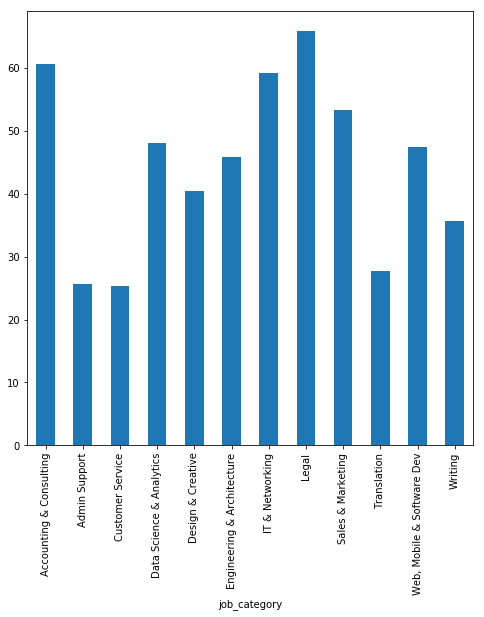

In [67]:
gender_table= merged.groupby('job_category')['bill_rate'].mean()
gender_table.plot(kind="bar", figsize=(8,8))

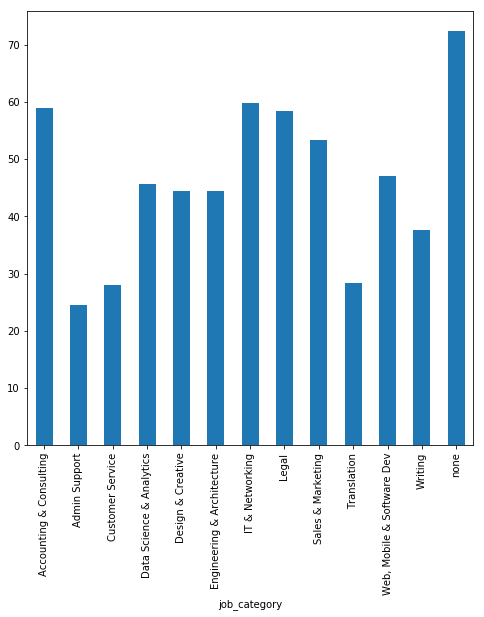

In [68]:
gender_table2= merged2.groupby('job_category')['bill_rate'].mean()
gender_table2.plot(kind="bar", figsize=(8,8))

## Percentage Men and Women Across Job Categories

                            Percentage Female Workers
IT & Networking                             16.959511
Engineering & Architecture                  18.333333
Web, Mobile & Software Dev                  19.123328
Data Science & Analytics                    26.387249
Design & Creative                           44.209413
Sales & Marketing                           48.391282
Accounting & Consulting                     48.789713
Legal                                       58.510638
Translation                                 63.499658
Customer Service                            64.546226
Writing                                     64.704732
Admin Support                               77.888583


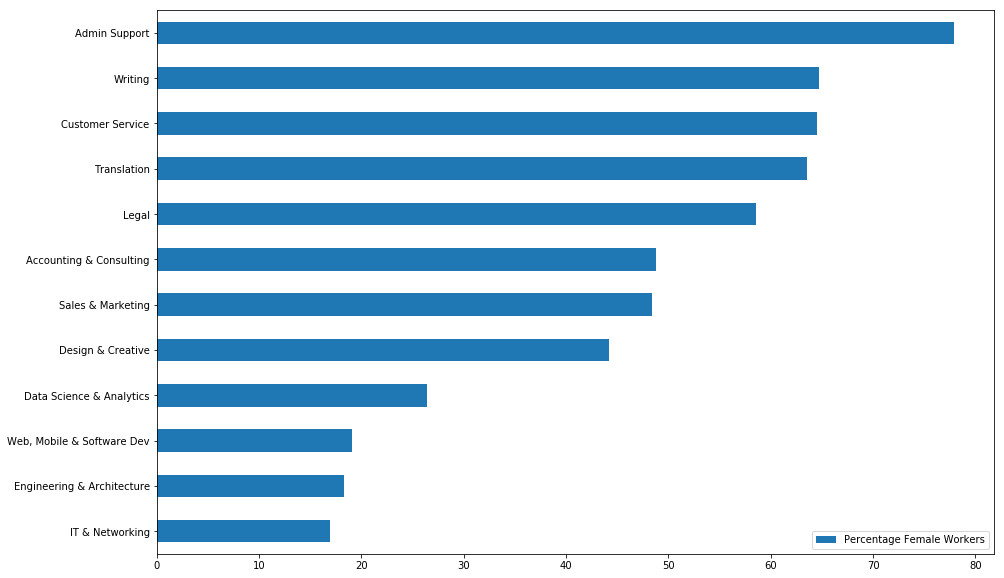

In [70]:
job_categories = ['Design & Creative', 'Data Science & Analytics', 'Customer Service', 'Admin Support', 
                 'Accounting & Consulting', 'Writing', 'Web, Mobile & Software Dev', 'Translation', 
                 'Sales & Marketing', 'Legal', 'IT & Networking', 'Engineering & Architecture']

representation_of_women = []
representation_gap = []

for category in job_categories:
    
    males_with_job = merged[(merged['gender_computer'] == 'male') & (merged['job_category'] == category)]
    male_total = len(males_with_job)
    
    # Calculate the female average bill rate
    females_with_job = merged[(merged['gender_computer'] == 'female') & (merged['job_category'] == category)]
    female_total = len(females_with_job)
    
    total_in_category = male_total + female_total
    
    female_percentage = float(female_total)/float(total_in_category) * 100

    representation_of_women.append(female_percentage)
    male_percentage = 100 - female_percentage
    representation_gap.append(male_percentage - female_percentage)
    

representation_df = pd.DataFrame(representation_of_women, index=job_categories, columns=['Percentage Female Workers'])

representation_df = representation_df.sort_values('Percentage Female Workers')
print (representation_df)

representation_df.plot(kind="barh", figsize=(15,10))


                            Female Representation Gap
Admin Support                              -55.777166
Writing                                    -29.409464
Customer Service                           -29.092451
Translation                                -26.999316
Legal                                      -17.021277
Accounting & Consulting                      2.420575
Sales & Marketing                            3.217436
Design & Creative                           11.581174
Data Science & Analytics                    47.225502
Web, Mobile & Software Dev                  61.753343
Engineering & Architecture                  63.333333
IT & Networking                             66.080978


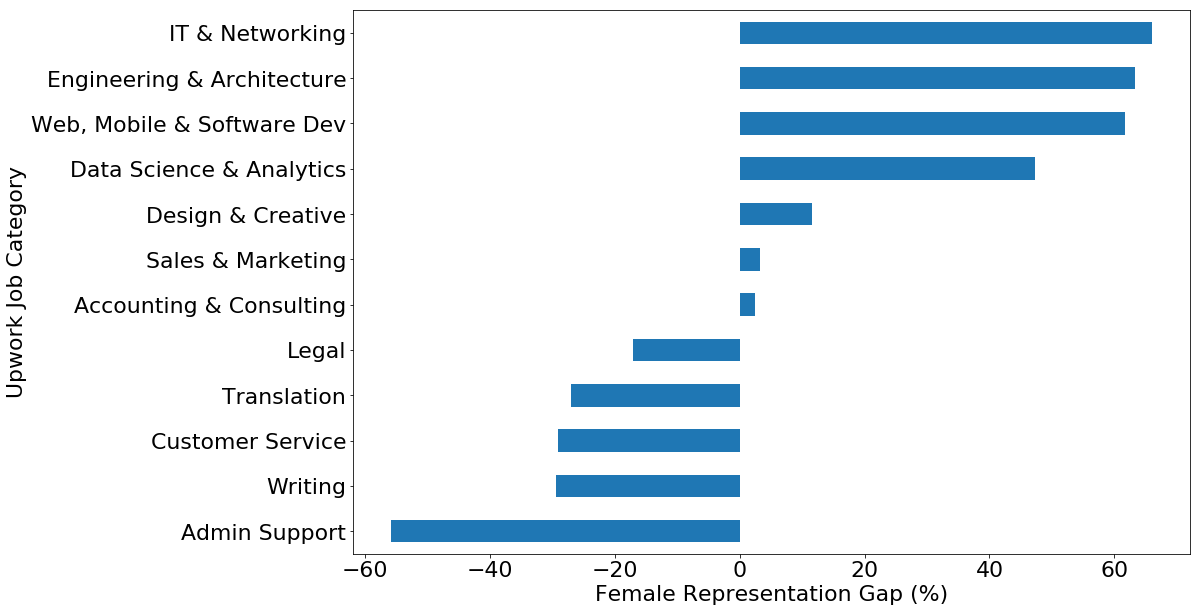

In [71]:
representation_gap_df = pd.DataFrame(representation_gap, index=job_categories, columns=['Female Representation Gap'])
representation_gap_df = representation_gap_df.sort_values('Female Representation Gap')
print (representation_gap_df)
plt.rcParams.update({'font.size': 22})
graph = representation_gap_df.plot(kind="barh", figsize=(15, 10), legend=None)
graph.set_xlabel("Female Representation Gap (%)")
graph.set_ylabel("Upwork Job Category")




## What are the highest paying job categories on Upwork?

                            median_bill_rate
Design & Creative                       30.0
Data Science & Analytics                40.0
Customer Service                        20.0
Admin Support                           20.0
Accounting & Consulting                 40.0
Writing                                 28.0
Web, Mobile & Software Dev              40.0
Translation                             25.0
Sales & Marketing                       40.0
Legal                                   40.0
IT & Networking                         50.0
Engineering & Architecture              36.5
Median by job category: 38.25


,median_bill_rate
Design & Creative,30.0
Data Science & Analytics,40.0
Customer Service,20.0
Admin Support,20.0
Accounting & Consulting,40.0
Writing,28.0
"Web, Mobile & Software Dev",40.0
Translation,25.0
Sales & Marketing,40.0
Legal,40.0


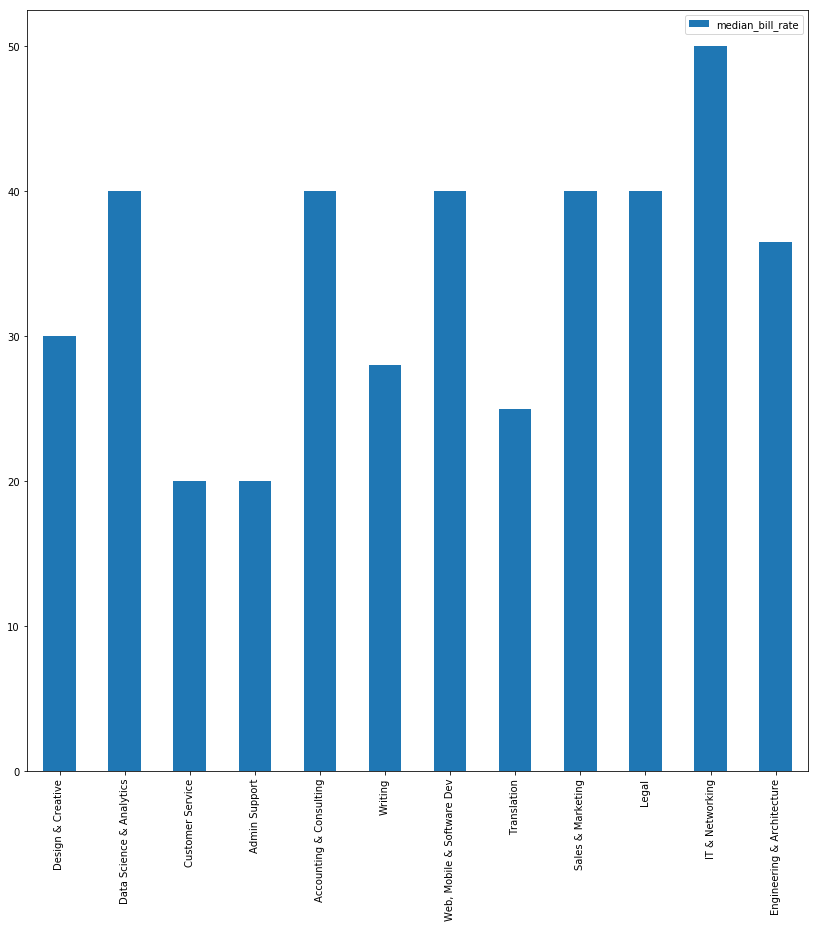

In [2]:
job_categories = ['Design & Creative', 'Data Science & Analytics', 'Customer Service', 'Admin Support', 
                 'Accounting & Consulting', 'Writing', 'Web, Mobile & Software Dev', 'Translation', 
                 'Sales & Marketing', 'Legal', 'IT & Networking', 'Engineering & Architecture']

average_bill_rate = []
median_bill_rate = []

total_length = 0

for category in job_categories:
    workers_with_job = merged[(merged['job_category'] == category)]['bill_rate']
    bill_rate_average = np.mean(workers_with_job)
    bill_rate_median = np.median(workers_with_job)
    total_length += len(workers_with_job)
    average_bill_rate.append(bill_rate_average)
    median_bill_rate.append(bill_rate_median)

bill_rate_df = pd.DataFrame(median_bill_rate, index=job_categories, columns=['median_bill_rate'])
#bill_rate_df = bill_rate_df.sort_values('average_bill_rate')

print (bill_rate_df)
bill_rate_df.plot(kind="bar", figsize=(14,14))

overall_median = np.median(median_bill_rate)
print ("Median by job category: {0}".format(overall_median))

bill_rate_df


## What are pay discrepancies across job categories?

In [4]:
from scipy.stats import chisquare

pay_discrepancies = []

job_categories = ['Design & Creative', 'Data Science & Analytics', 'Customer Service', 'Admin Support', 
                 'Accounting & Consulting', 'Writing', 'Web, Mobile & Software Dev', 'Translation', 
                 'Sales & Marketing', 'Legal', 'IT & Networking', 'Engineering & Architecture']


list_of_discrepancies = []
list_of_employability = []
list_of_jobs_worked = []
list_of_male_hourly_revenue = []
list_of_female_hourly_revenue = []
list_of_female_representation = []
list_number_of_females = []
list_number_of_males = []
percentage_medians = []

for category in job_categories:
    # Calculate the male average bill rate
    males = merged[(merged['gender_computer'] == 'male') & (merged['job_category'] == category) & merged['hours_worked'] > 0]
    males_with_job = males['bill_rate']
    number_of_males = len(males_with_job)
    males_hours = males['hours_worked']
    males_jobs = males['jobs_completed']
    male_bill_rate_average = np.mean(males_with_job)
    male_bill_rate_median = np.median(males_with_job)
    male_hours_worked = np.median(males_hours)
    male_jobs_worked = np.mean(males_jobs)
    
    male_hourly_revenue = males['estimated_hourly_revenue']
    list_of_male_hourly_revenue.append(np.median(male_hourly_revenue))
    

    # Calculate the female average bill rate
    females = merged[(merged['gender_computer'] == 'female') & (merged['job_category'] == category) & merged['hours_worked'] > 0]
    females_with_job = females['bill_rate']
    number_of_females = len(females_with_job)
    females_hours = females['hours_worked']
    females_jobs = females['jobs_completed']
    female_bill_rate_average = np.mean(females_with_job)
    female_bill_rate_median = np.median(females_with_job)
    female_hours_worked = np.median(females_hours)
    female_jobs_worked = np.mean(females_jobs)
    
    female_hourly_revenue = females['estimated_hourly_revenue']
    list_of_female_hourly_revenue.append(np.median(female_hourly_revenue))
    
    female_representation = float(number_of_females)/float(number_of_males) 
    female_percentage = float(female_bill_rate_average)/float(male_bill_rate_average) * 100
    female_percentage_median = float(female_bill_rate_median)/float(male_bill_rate_median) * 100
    discrepancy = 100 - female_percentage
    list_of_discrepancies.append(discrepancy)
    
    # Do Kruskal-Wallis-H test for each category to see if median female vs. male revenue is diff
    print ("------{0}------").format(category)
    print (stats.ks_2samp(female_hourly_revenue, male_hourly_revenue))
    print (stats.levene(female_hourly_revenue, male_hourly_revenue))
    #transformed_female_revenue = stats.boxcox(female_hourly_revenue)
    #transformed_male_revenue = stats.boxcox(male_hourly_revenue)
    #print (stats.skew(transformed_female_revenue[0]))
    #print (stats.skew(transformed_male_revenue[0]))
    #print ("Female hourly revenue: {0}; Male hourly revenue: {1}").format(np.median(transformed_female_revenue[0]), np.median(transformed_male_revenue[0]))
    #print stats.mannwhitneyu(np.array(male_hourly_revenue), np.array(female_hourly_revenue))
    #females.hist(column='estimated_hourly_revenue', figsize=(8,8), color="red", bins=50)
    #males.hist(column='estimated_hourly_revenue', figsize=(8,8), color="blue", bins=50)
    
    hours_percentage = 0
    hours_discrepancy = 0
    
    if male_hours_worked > female_hours_worked:
        hours_percentage = float(female_hours_worked)/float(male_hours_worked) * 100
        hours_discrepancy = -(100-hours_percentage)
    elif female_hours_worked > male_hours_worked:
        hours_percentage = float(male_hours_worked)/float(female_hours_worked) * 100
        hours_discrepancy = 100- hours_percentage
        
    if male_jobs_worked > female_jobs_worked:
        jobs_percentage = float(female_jobs_worked)/float(male_jobs_worked) * 100
        jobs_discrepancy = -(100-jobs_percentage)
    elif female_jobs_worked > male_jobs_worked:
        jobs_percentage = float(male_jobs_worked)/float(female_jobs_worked) * 100
        jobs_discrepancy = 100-jobs_percentage
    
    list_of_employability.append(hours_discrepancy)
    list_of_jobs_worked.append(jobs_discrepancy)
    list_of_female_representation.append(female_representation)
    
    print ("Male bill rate average: {0}".format(male_bill_rate_average))
    print ("Male hours worked: {0}").format(male_hours_worked)
    print ("Female bill rate average: {0}".format(female_bill_rate_average))
    print ("Female hours worked: {0}").format(female_hours_worked)
    print ("Pay discrepancy: {0}%".format(discrepancy))
    print ("Female employability: {0}%").format(hours_discrepancy)
    print ("Female jobs worked: {0}%").format(jobs_discrepancy)
    print ("Female representation: {0}%").format(female_representation)
    
    percentage_bill_rate_median = float(female_bill_rate_median) / float(male_bill_rate_median) * 100
    print ("Female bill rate median: {0}").format(female_bill_rate_median)
    print ("Male bill rate median: {0}").format(male_bill_rate_median)
    print ("Median as a percentage: {0}").format(percentage_bill_rate_median)
    percentage_medians.append(percentage_bill_rate_median)
    
    # Do chi square analysis for each category
    # print ("Chi square: {0}").format(chisquare([number_of_females, number_of_males]))
    
    list_number_of_females.append(number_of_females)
    list_number_of_males.append(number_of_males)    

print percentage_medians

print list_of_female_hourly_revenue
print list_of_male_hourly_revenue

discrepancy_df = pd.DataFrame(list_of_discrepancies, index=job_categories, columns=['pay_discrepancy'])
employability_df = pd.DataFrame(list_of_employability, index=job_categories, columns=['female_employability'])
jobs_worked_df = pd.DataFrame(list_of_jobs_worked, index=job_categories, columns=['female_jobs_worked'])
female_hourly_revenue_df = pd.DataFrame(list_of_female_hourly_revenue, index=job_categories, columns=['female_hourly_revenue'])
male_hourly_revenue_df = pd.DataFrame(list_of_male_hourly_revenue, index=job_categories, columns=['male_hourly_revenue'])
female_representation_df = pd.DataFrame(list_of_female_representation, index=job_categories, columns=['female_representation'])

discrepancy_df = employability_df.join(discrepancy_df, how='outer')
discrepancy_df = discrepancy_df.join(jobs_worked_df, how='outer')
discrepancy_df = discrepancy_df.join(female_hourly_revenue_df, how='outer')
discrepancy_df = discrepancy_df.join(male_hourly_revenue_df, how='outer')
discrepancy_df = discrepancy_df.join(female_representation_df, how='outer')

discrepancy_df = discrepancy_df.join(bill_rate_df, how='outer')
#discrepancy_df = discrepancy_df.sort_values('pay_discrepancy')

discrepancy_df 

# Do chi square analysis for each category
from scipy.stats import chi2_contingency
obs = np.array([list_number_of_females, list_number_of_males])
print ("Chi square: {0}").format(chi2_contingency(obs))

# Correlation between median bill rate and female representation across categories
correlation_df = bill_rate_df.join(female_representation_df, how='outer')
print correlation_df.corr()
print len(correlation_df)

------Design & Creative------
Ks_2sampResult(statistic=0.035914132176183305, pvalue=0.61366176960425567)
LeveneResult(statistic=0.11979315913883375, pvalue=0.72930032592463756)
Male bill rate average: 41.3040732265
Male hours worked: 23.999999995
Female bill rate average: 37.9036414882
Female hours worked: 24.83333332
Pay discrepancy: 8.23267894121%
Female employability: 3.35570466623%
Female jobs worked: 8.21650714196%
Female representation: 1.01487414188%
Female bill rate median: 30.0
Male bill rate median: 35.0
Median as a percentage: 85.7142857143
------Data Science & Analytics------
Ks_2sampResult(statistic=0.063787618004485513, pvalue=0.95929275047156037)
LeveneResult(statistic=1.7847743536166425, pvalue=0.18253777656090706)
Male bill rate average: 54.5857575758
Male hours worked: 34.66666667
Female bill rate average: 40.1386746988
Female hours worked: 52.99999999
Pay discrepancy: 26.4667626109%
Female employability: 34.5911949499%
Female jobs worked: -23.2467182161%
Female repre

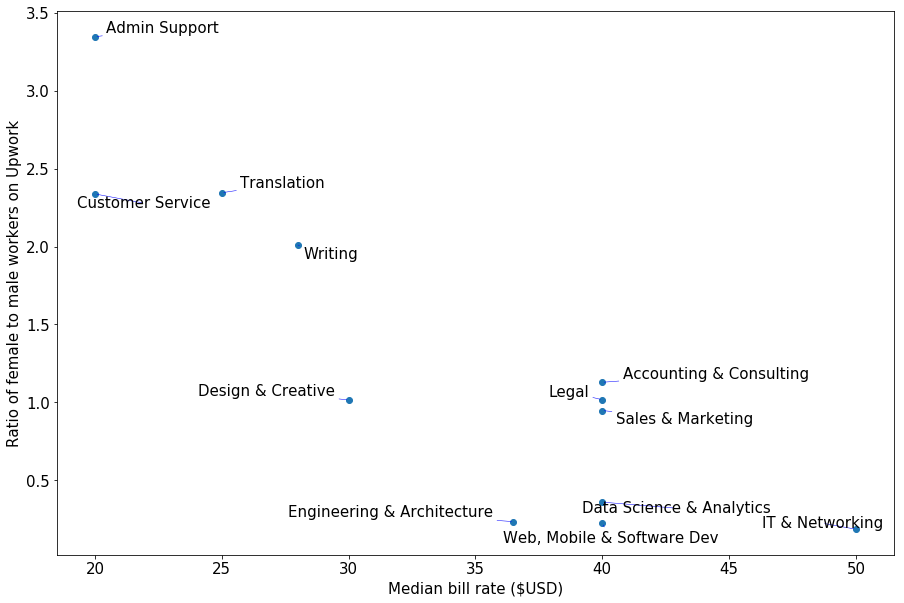

In [97]:
from adjustText import adjust_text
n=['Design & Creative', 'Data Science & Analytics', 'Customer Service', 'Admin Support', 
                 'Accounting & Consulting', 'Writing', 'Web, Mobile & Software Dev', 'Translation', 
                 'Sales & Marketing', 'Legal', 'IT & Networking', 'Engineering & Architecture']


fig, ax = plt.subplots()
ax.scatter(discrepancy_df.median_bill_rate, discrepancy_df.female_representation)

texts = []
for x, y, s in zip(discrepancy_df.median_bill_rate, discrepancy_df.female_representation, n):
    texts.append(plt.text(x, y, s))

adjust_text(texts, only_move='y', arrowprops=dict(arrowstyle="-", color='b', lw=0.5))

from pylab import rcParams
import matplotlib
rcParams['figure.figsize'] = 15,10
matplotlib.rcParams.update({'font.size': 15})
ax.set_xlabel('Median bill rate ($USD)')
ax.set_ylabel('Ratio of female to male workers on Upwork')
plt.show()




                            female_employability  pay_discrepancy  \
Design & Creative                       3.355705         8.232679   
Data Science & Analytics               34.591195        26.466763   
Customer Service                       60.368537        14.512893   
Admin Support                          49.637306        28.575139   
Accounting & Consulting                67.763158        37.156268   
Writing                                46.987952        14.676596   
Web, Mobile & Software Dev             13.520408        15.169933   
Translation                            84.010840         6.964588   
Sales & Marketing                      42.432432        16.798945   
Legal                                  12.941176        50.998891   
IT & Networking                         8.196721        21.795429   
Engineering & Architecture             13.348416        33.015444   

                            female_jobs_worked  female_hourly_revenue  \
Design & Creative            

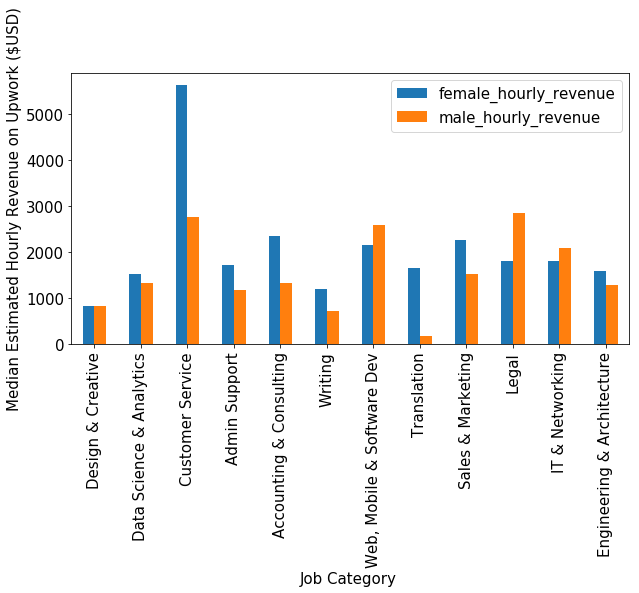

In [98]:
non_revenue_columns = ['female_employability', 'pay_discrepancy', 'female_jobs_worked', 'median_bill_rate', 'female_representation']

print discrepancy_df

discrepancy_df.drop(non_revenue_columns, axis=1, inplace=True)
graph = discrepancy_df.plot(kind="bar", figsize=(10,5))
plt.xticks(rotation='vertical')
graph.set_xlabel("Job Category ")
graph.set_ylabel("Median Estimated Hourly Revenue on Upwork ($USD)")

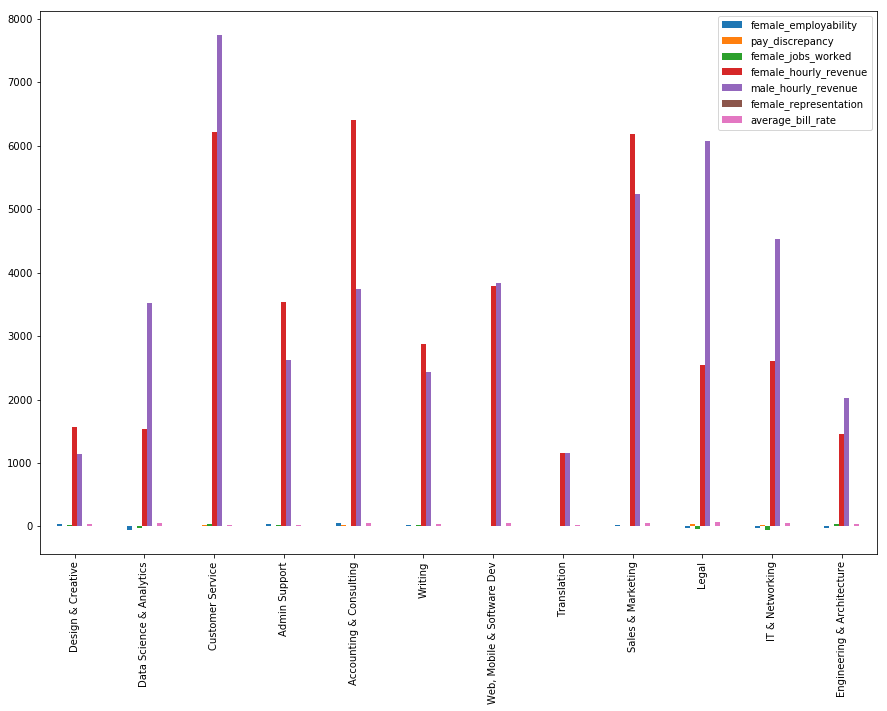

In [13]:
discrepancy_df.plot(kind="bar", figsize=(15,10))

In [10]:
discrepancy_df

,female_employability,pay_discrepancy,female_jobs_worked,female_hourly_revenue,male_hourly_revenue,female_representation
Translation,59.313766,-0.549662,6.108597,6192.262189,2505.625788,200.000000
Customer Service,32.070899,5.371361,41.079445,19506.606109,14002.803407,219.354839
Design & Creative,32.920346,8.703595,29.034790,5327.614504,3914.442578,88.308740
"Web, Mobile & Software Dev",20.341854,16.254602,34.270598,12911.912482,12281.737757,20.905923
Writing,19.225489,18.469688,23.346779,6063.521881,6007.311884,195.335609
Sales & Marketing,21.055437,20.171646,31.875846,14735.968852,14572.824808,93.240093
Admin Support,55.225985,24.735262,35.223111,13819.693958,8221.156416,295.111111
Engineering & Architecture,-34.355397,26.043110,38.559450,5154.890827,10617.977646,33.742331
Data Science & Analytics,-63.965624,27.505367,-39.246250,3856.608605,14763.275090,37.823834
Accounting & Consulting,63.596672,29.037179,18.130345,22654.368442,11621.499905,82.386364


In [11]:
mean_female_revenue = np.mean(discrepancy_df['female_hourly_revenue'])
mean_male_revenue = np.mean(discrepancy_df['male_hourly_revenue'])
std_female_revenue = np.std(discrepancy_df['female_hourly_revenue'])
std_male_revenue = np.std(discrepancy_df['male_hourly_revenue'])

print "Mean female revenue: {0}".format(mean_female_revenue)
print "Std female revenue: {0}".format(std_female_revenue)
print "Mean male revenue: {0}".format(mean_male_revenue)
print "Std male revenue: {0}".format(std_male_revenue)

Mean female revenue: 10465.250483
Std female revenue: 5908.58909649
Mean male revenue: 10833.1269989
Std male revenue: 4557.94614138


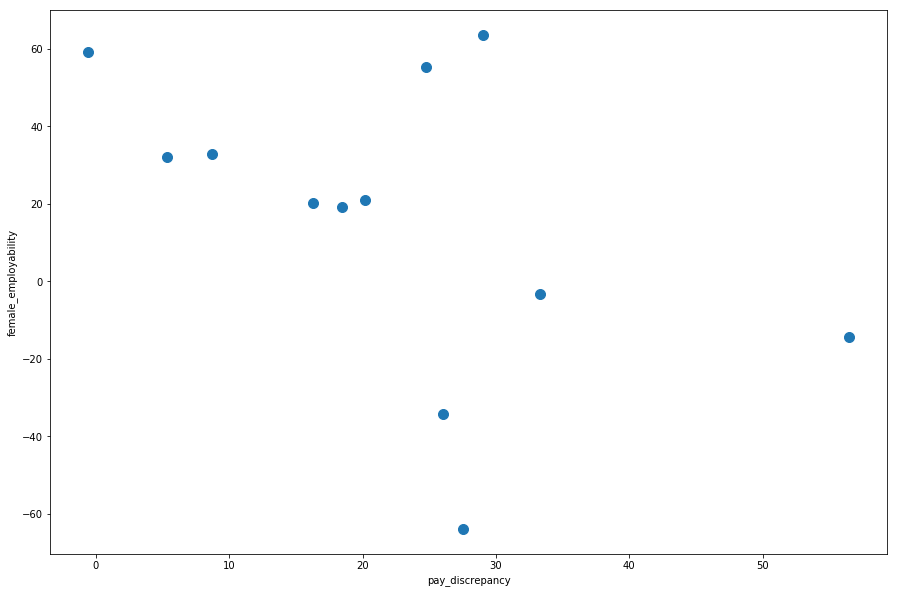

In [12]:
discrepancy_df.plot(kind='scatter', x='pay_discrepancy', y='female_employability', figsize=(15, 10), s=100)

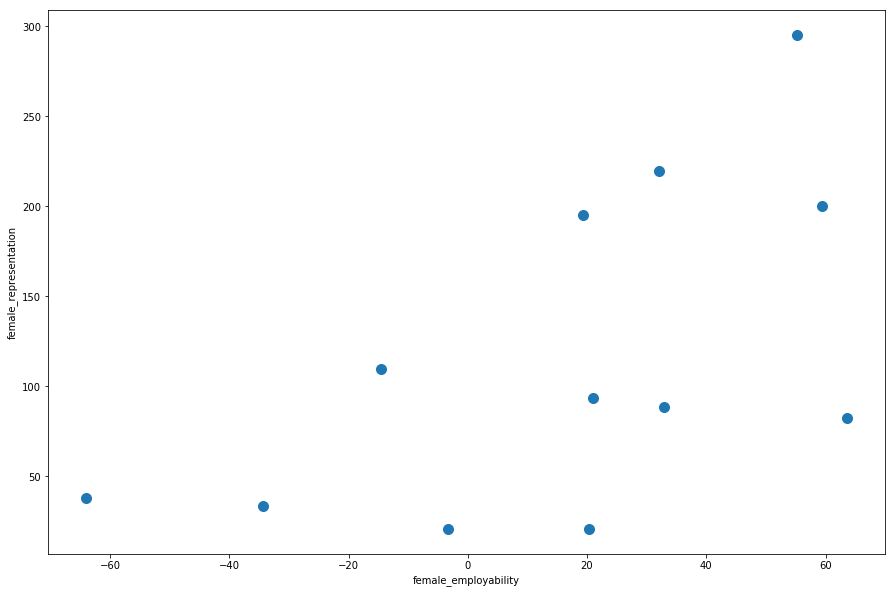

In [13]:
discrepancy_df.plot(kind='scatter', x='female_employability', y='female_representation', figsize=(15, 10), s=100)

In [14]:
print discrepancy_df

correlation_matrix = np.corrcoef(discrepancy_df.T)
print correlation_matrix

                            female_employability  pay_discrepancy  \
Translation                            59.313766        -0.549662   
Customer Service                       32.070899         5.371361   
Design & Creative                      32.920346         8.703595   
Web, Mobile & Software Dev             20.341854        16.254602   
Writing                                19.225489        18.469688   
Sales & Marketing                      21.055437        20.171646   
Admin Support                          55.225985        24.735262   
Engineering & Architecture            -34.355397        26.043110   
Data Science & Analytics              -63.965624        27.505367   
Accounting & Consulting                63.596672        29.037179   
IT & Networking                        -3.273919        33.338632   
Legal                                 -14.486480        56.469069   

                            female_jobs_worked  female_hourly_revenue  \
Translation                  

In [15]:
correlation_matrix = np.corrcoef(discrepancy_df.T)
print correlation_matrix

[[ 1.         -0.47119485  0.51818114  0.58858918 -0.52093372  0.58269526]
 [-0.47119485  1.         -0.47219445 -0.10300124  0.67894205 -0.32144984]
 [ 0.51818114 -0.47219445  1.          0.41735595 -0.32095951  0.38919955]
 [ 0.58858918 -0.10300124  0.41735595  1.          0.26227184  0.22587157]
 [-0.52093372  0.67894205 -0.32095951  0.26227184  1.         -0.39261594]
 [ 0.58269526 -0.32144984  0.38919955  0.22587157 -0.39261594  1.        ]]


In [16]:
model = ols("female_employability ~ pay_discrepancy", discrepancy_df).fit()
print model.summary()
print model.params

                             OLS Regression Results                             
Dep. Variable:     female_employability   R-squared:                       0.222
Model:                              OLS   Adj. R-squared:                  0.144
Method:                   Least Squares   F-statistic:                     2.854
Date:                  Fri, 06 Apr 2018   Prob (F-statistic):              0.122
Time:                          11:21:09   Log-Likelihood:                -58.881
No. Observations:                    12   AIC:                             121.8
Df Residuals:                        10   BIC:                             122.7
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          42.

/home/ecf384/.conda/envs/eureka2/lib/python2.7/site-packages/scipy/stats/stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  "anyway, n=%i" % int(n))


In [17]:
model = ols("female_employability ~ female_representation", discrepancy_df).fit()
print model.summary()
print model.params

                             OLS Regression Results                             
Dep. Variable:     female_employability   R-squared:                       0.340
Model:                              OLS   Adj. R-squared:                  0.273
Method:                   Least Squares   F-statistic:                     5.141
Date:                  Fri, 06 Apr 2018   Prob (F-statistic):             0.0468
Time:                          11:21:46   Log-Likelihood:                -57.899
No. Observations:                    12   AIC:                             119.8
Df Residuals:                        10   BIC:                             120.8
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept 

### Do the same thing, but do not include the Legal, IT and Data Science, which have opposite patterns

In [25]:
discrepancy_df_mod = discrepancy_df[(discrepancy_df.index != 'Data Science & Analytics') &
                                   (discrepancy_df.index != 'IT & Networking') &
                                   (discrepancy_df.index != 'Legal')]

print discrepancy_df_mod
correlation_matrix = np.corrcoef(discrepancy_df_mod.T)
print correlation_matrix

                            female_employability  pay_discrepancy  \
Translation                            59.313766        -0.549662   
Customer Service                       32.070899         5.371361   
Design & Creative                      32.920346         8.703595   
Web, Mobile & Software Dev             20.341854        16.254602   
Writing                                19.225489        18.469688   
Sales & Marketing                      21.055437        20.171646   
Admin Support                          55.225985        24.735262   
Engineering & Architecture            -34.355397        26.043110   
Accounting & Consulting                63.596672        29.037179   

                            female_jobs_worked  
Translation                           6.108597  
Customer Service                     41.079445  
Design & Creative                    29.034790  
Web, Mobile & Software Dev           34.270598  
Writing                              23.346779  
Sales & Marketi

## Note: These scatterplots didn't run properly and are based on previous final_gender dataset

                            average_bill_rate  Percentage Female Workers  \
Accounting & Consulting             60.531309                  48.789713   
Admin Support                       25.611518                  77.888583   
Customer Service                    25.302824                  64.546226   
Data Science & Analytics            47.969545                  26.387249   
Design & Creative                   40.489624                  44.209413   
Engineering & Architecture          45.849529                  18.333333   
IT & Networking                     59.194966                  16.959511   
Legal                               65.808989                  58.510638   
Sales & Marketing                   53.232213                  48.391282   
Translation                         27.763500                  63.499658   
Web, Mobile & Software Dev          47.409602                  19.123328   
Writing                             35.593824                  64.704732   

           

KeyError: 'female_percentage'

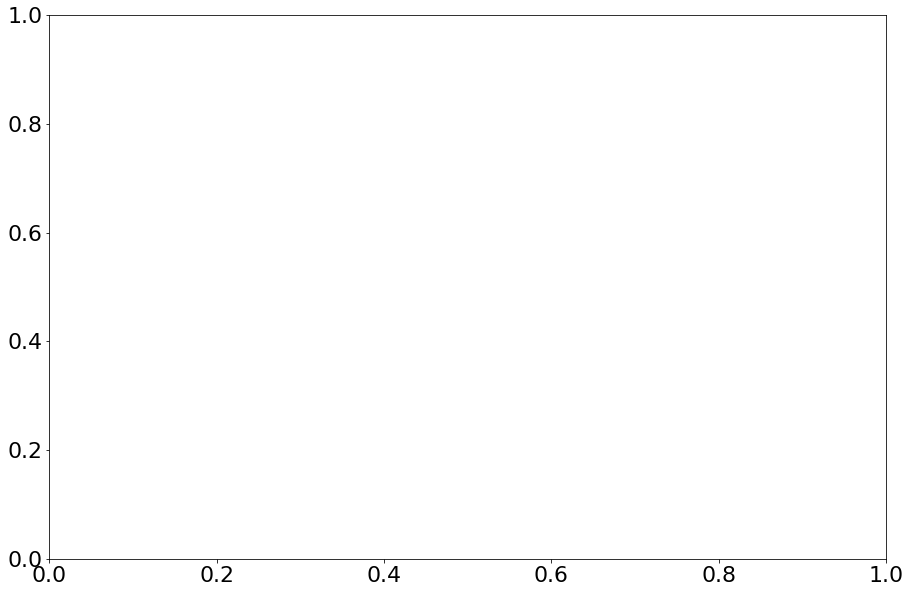

In [78]:
# Build a scatterplot using the dataframes above

scatter_df = bill_rate_df.join(representation_df, how='outer')

scatter_df = scatter_df.join(discrepancy_df, how='outer')

print (scatter_df)

scatter_df.plot(kind='scatter', x='average_bill_rate', y='female_percentage', figsize=(15, 10), s=100)

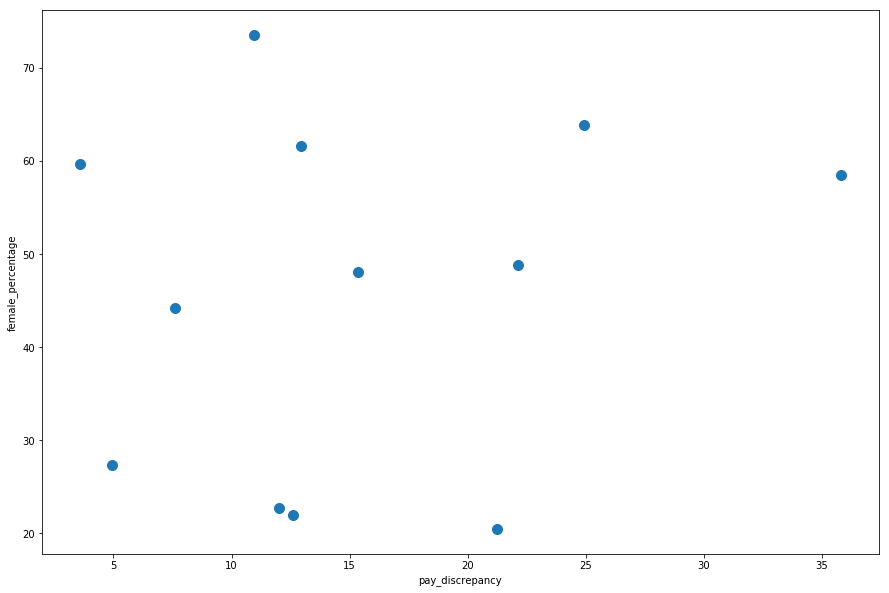

In [142]:
scatter_df.plot(kind='scatter', x='pay_discrepancy', y='female_percentage', figsize=(15, 10), s=100)

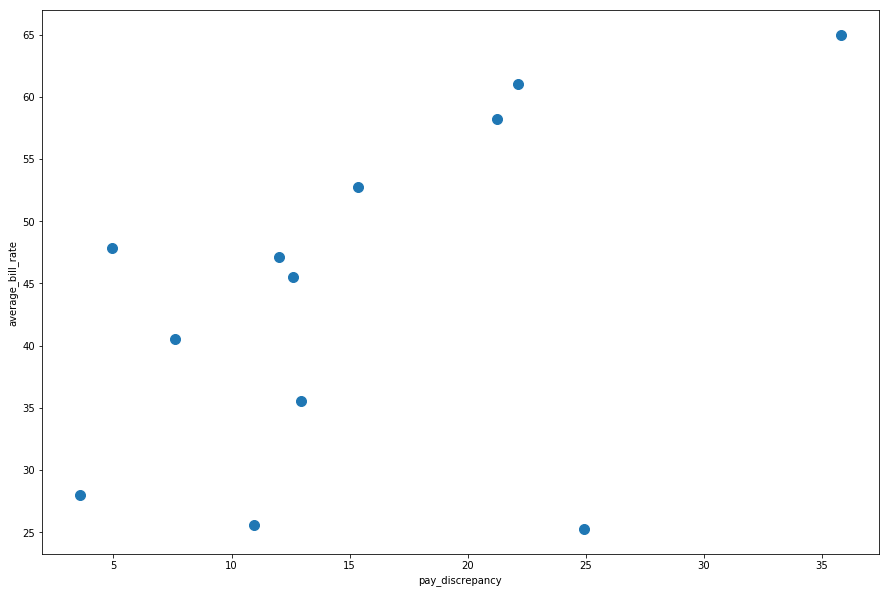

In [143]:
scatter_df.plot(kind='scatter', x='pay_discrepancy', y='average_bill_rate', figsize=(15, 10), s=100)

## Highest Level of Education by Gender

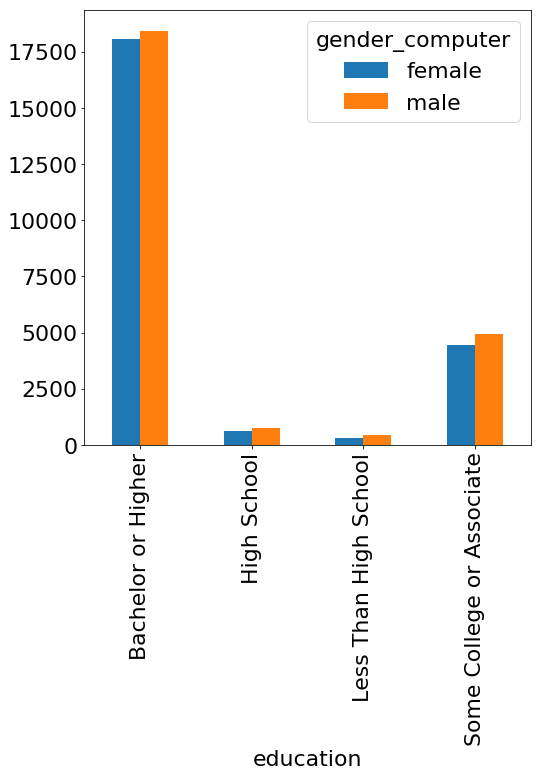

In [80]:
education_table = pd.crosstab(merged['education'], merged['gender_computer'])
education_table.plot(kind="bar", figsize=(8,8))

## Primary Job Category by Gender

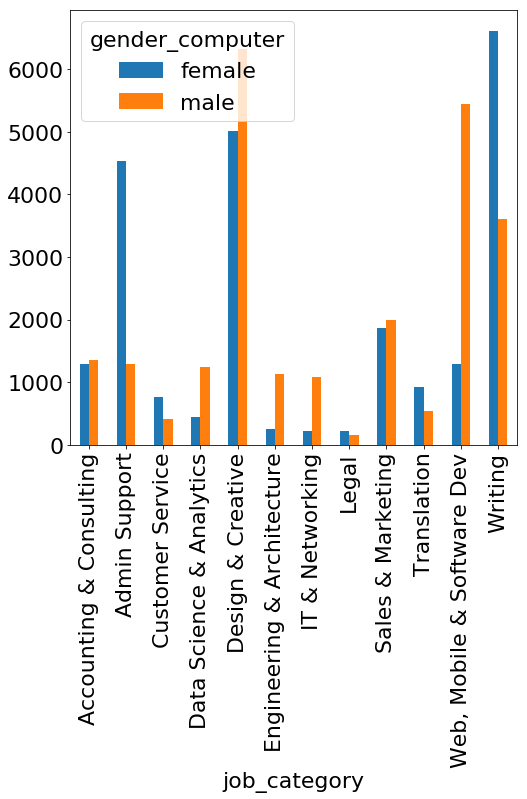

In [82]:
job_category_table = pd.crosstab(merged['job_category'], merged['gender_computer'])
job_category_table.plot(kind="bar", figsize=(8,8))

## Work Experience by Gender and Age

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb939ff2d10>]], dtype=object)

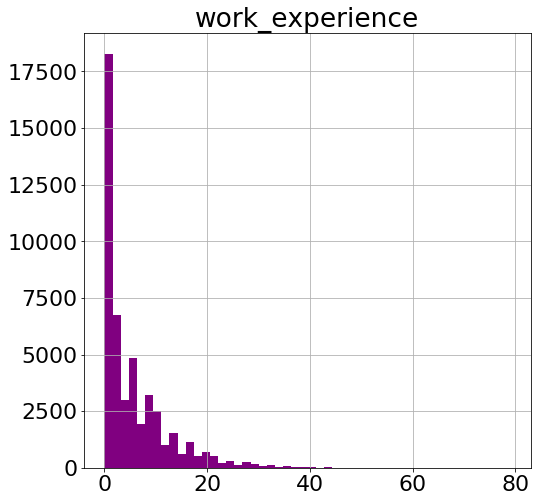

In [83]:
# Get work experience distribution 
merged.hist(column='work_experience', figsize=(8,8), color="purple", bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb939e4c590>]], dtype=object)

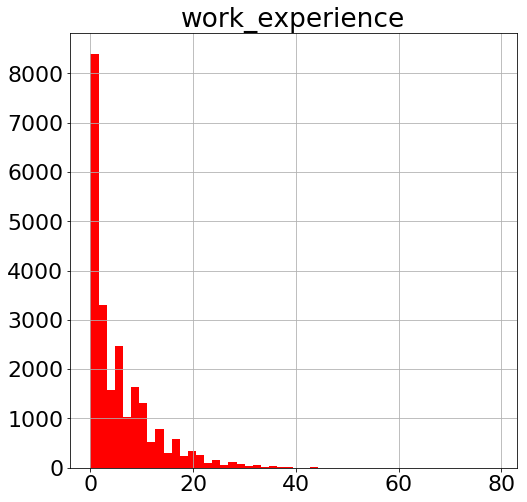

In [84]:
# Work experience distribution for women 
female_df = merged[merged['gender_computer'] == 'female']

female_df.hist(column='work_experience', figsize=(8,8), color="red", bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb939bba690>]], dtype=object)

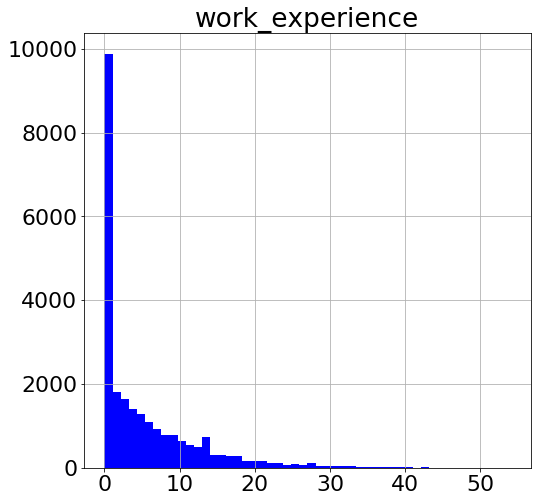

In [85]:
# Work experience distribution for men 
male_df = merged[merged['gender_computer'] == 'male']
male_df.hist(column='work_experience', figsize=(8,8), color="blue", bins=50)

In [86]:
sd = np.std(merged['work_experience'])
mean = np.mean(merged['work_experience'])
median = np.median(merged['work_experience'])
print("Work experience average: {0}".format(mean))
print("Work experience standard deviation: {0}".format(sd))
print("Work experience median: {0}".format(median))

work_experience_table= merged.groupby('gender_computer')['work_experience'].mean()
print ("Average work experience")
print (work_experience_table)

work_experience_table= merged.groupby('gender_computer')['work_experience'].median()
print ("Median work experience")
print (work_experience_table)

work_experience_table= merged.groupby('gender_computer')['work_experience'].std()
print ("Standard deviation of work experience")
print (work_experience_table)

Work experience average: 5.47968512464
Work experience standard deviation: 6.84717724679
Work experience median: 3.0
Average work experience
gender_computer
female    5.576884
male      5.387006
Name: work_experience, dtype: float64
Median work experience
gender_computer
female    4.0
male      3.0
Name: work_experience, dtype: float64
Standard deviation of work experience
gender_computer
female    6.647498
male      7.031313
Name: work_experience, dtype: float64


## Hours Worked On Upwork by Gender

In [87]:
merged['hours_worked'] = merged['hours_worked'].astype('float')

sd = np.std(merged['hours_worked'])
mean = np.mean(merged['hours_worked'])
median = np.median(merged['hours_worked'])
print("Hours worked average: {0}".format(mean))
print("Hours worked standard deviation: {0}".format(sd))
print("Hours worked median: {0}".format(median))

hours_table= merged.groupby('gender_computer')['hours_worked'].mean()
print ("Average Hours worked")
print (hours_table)

hours_table= merged.groupby('gender_computer')['hours_worked'].median()
print ("Median Hours worked")
print (hours_table)

hours_table= merged.groupby('gender_computer')['hours_worked'].std()
print ("Standard deviation of Hours worked")
print (hours_table)

Hours worked average: 78.8691188127
Hours worked standard deviation: 564.412262474
Hours worked median: 0.0
Average Hours worked
gender_computer
female    95.381427
male      63.124622
Name: hours_worked, dtype: float64
Median Hours worked
gender_computer
female    0.0
male      0.0
Name: hours_worked, dtype: float64
Standard deviation of Hours worked
gender_computer
female    645.410167
male      473.965136
Name: hours_worked, dtype: float64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb939ae7ed0>]], dtype=object)

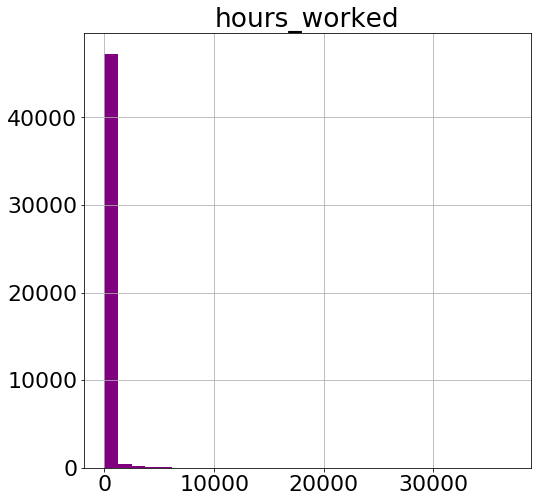

In [88]:
# Get hours worked distribution 
merged.hist(column='hours_worked', figsize=(8,8), color="purple", bins=30)

### Of those people who have worked at least a portion of an hour

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f92467ce350>]], dtype=object)

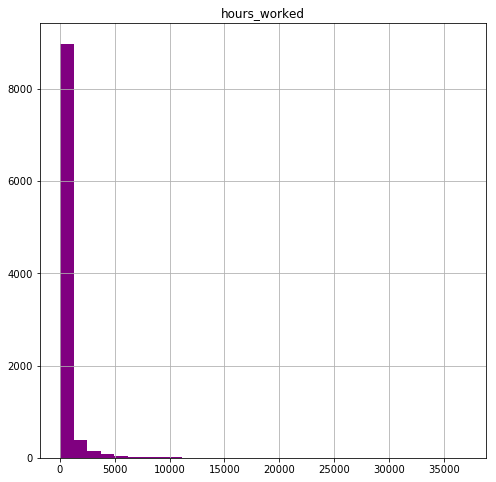

In [3]:
merged_active = merged[merged['hours_worked'] > 0]
merged_active.hist(column='hours_worked', figsize=(8,8), color="purple", bins=30)

In [4]:
print ("Total number of active users: {0}".format(len(merged_active)))
print ("Number of female active users: {0}".format(len(merged_active[merged_active['gender_computer'] == 'female'])))
print ("Number of male active users: {0}".format(len(merged_active[merged_active['gender_computer'] == 'male'])))

sd = np.std(merged_active['hours_worked'])
mean = np.mean(merged_active['hours_worked'])
median = np.median(merged_active['hours_worked'])
print("Hours worked average: {0}".format(mean))
print("Hours worked standard deviation: {0}".format(sd))
print("Hours worked median: {0}".format(median))

hours_table= merged_active.groupby('gender_computer')['hours_worked'].mean()
print ("Average Hours worked")
print (hours_table)

hours_table= merged_active.groupby('gender_computer')['hours_worked'].median()
print ("Median Hours worked")
print (hours_table)

hours_table= merged_active.groupby('gender_computer')['hours_worked'].std()
print ("Standard deviation of Hours worked")
print (hours_table)

Total number of active users: 9747
Number of female active users: 5121
Number of male active users: 4626
Hours worked average: 388.551986895
Hours worked standard deviation: 1203.77617869
Hours worked median: 40.00000001
Average Hours worked
gender_computer
female    436.545574
male      335.422899
Name: hours_worked, dtype: float64
Median Hours worked
gender_computer
female    48.833333
male      32.500000
Name: hours_worked, dtype: float64
Standard deviation of Hours worked
gender_computer
female    1325.832086
male      1050.014945
Name: hours_worked, dtype: float64


In [22]:
def create_barbell_chart(dataset, variable): # Creates a barbell chart for all job categories 
    
    labels = ["Accounting & Consulting", "Admin Support", "Customer Service", "Data Science & Analytics",
                          "Design & Creative", "Engineering & Architecture", "IT & Networking", 
                          "Legal", "Sales & Marketing", "Translation", "Web, Mobile & Software Dev", 
                          "Writing"]

    female_values = []
    male_values = []

    for job in labels:
        # Calculate female earnings
        df_female_dumbbell = dataset[(dataset['job_category'] == job) & (dataset['gender_computer'] == "female")]
        female_mean = round(np.mean(df_female_dumbbell[variable]), 0)
        female_mean = int(female_mean)

        # Calculate male earnings
        df_male_dumbbell = dataset[(dataset['job_category'] == job) & (dataset['gender_computer'] == "male")]
        male_mean = round(np.mean(df_male_dumbbell[variable]), 0)
        male_mean = int(male_mean)

        female_values.append(female_mean)
        male_values.append(male_mean)

    print (female_values)
    print (male_values)

    a_values = female_values
    b_values = male_values

    # Create the figure
    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(111)

    for i in list(range(len(labels))):
        # Plot the line between dumbbells
        ax.plot([a_values[i], b_values[i]], [i, i], color='black')
        # Plot the dumbbells.
        ax.plot(a_values[i], i, color='red', marker='o', markersize=35)
        ax.plot(b_values[i], i, color='blue', marker='o', markersize=35)
        # Add data label on top of dumbbells
        ax.text(a_values[i], i, a_values[i], horizontalalignment='center', verticalalignment='center', color='white', fontsize=22)
        ax.text(b_values[i], i, b_values[i], horizontalalignment='center', verticalalignment='center', color='white', fontsize=22)
        # Add the axis label
        ax.text(3, i, labels[i], horizontalalignment='right', verticalalignment='center', fontsize=28)

    # Adjust and show the plot
    fig.subplots_adjust(left=0.3)
    ax.set_axis_off()
    plt.show()

## Hours worked by job category

[684, 762, 1155, 195, 229, 200, 308, 180, 507, 306, 510, 296]
[347, 463, 1284, 381, 199, 260, 393, 183, 365, 393, 418, 237]


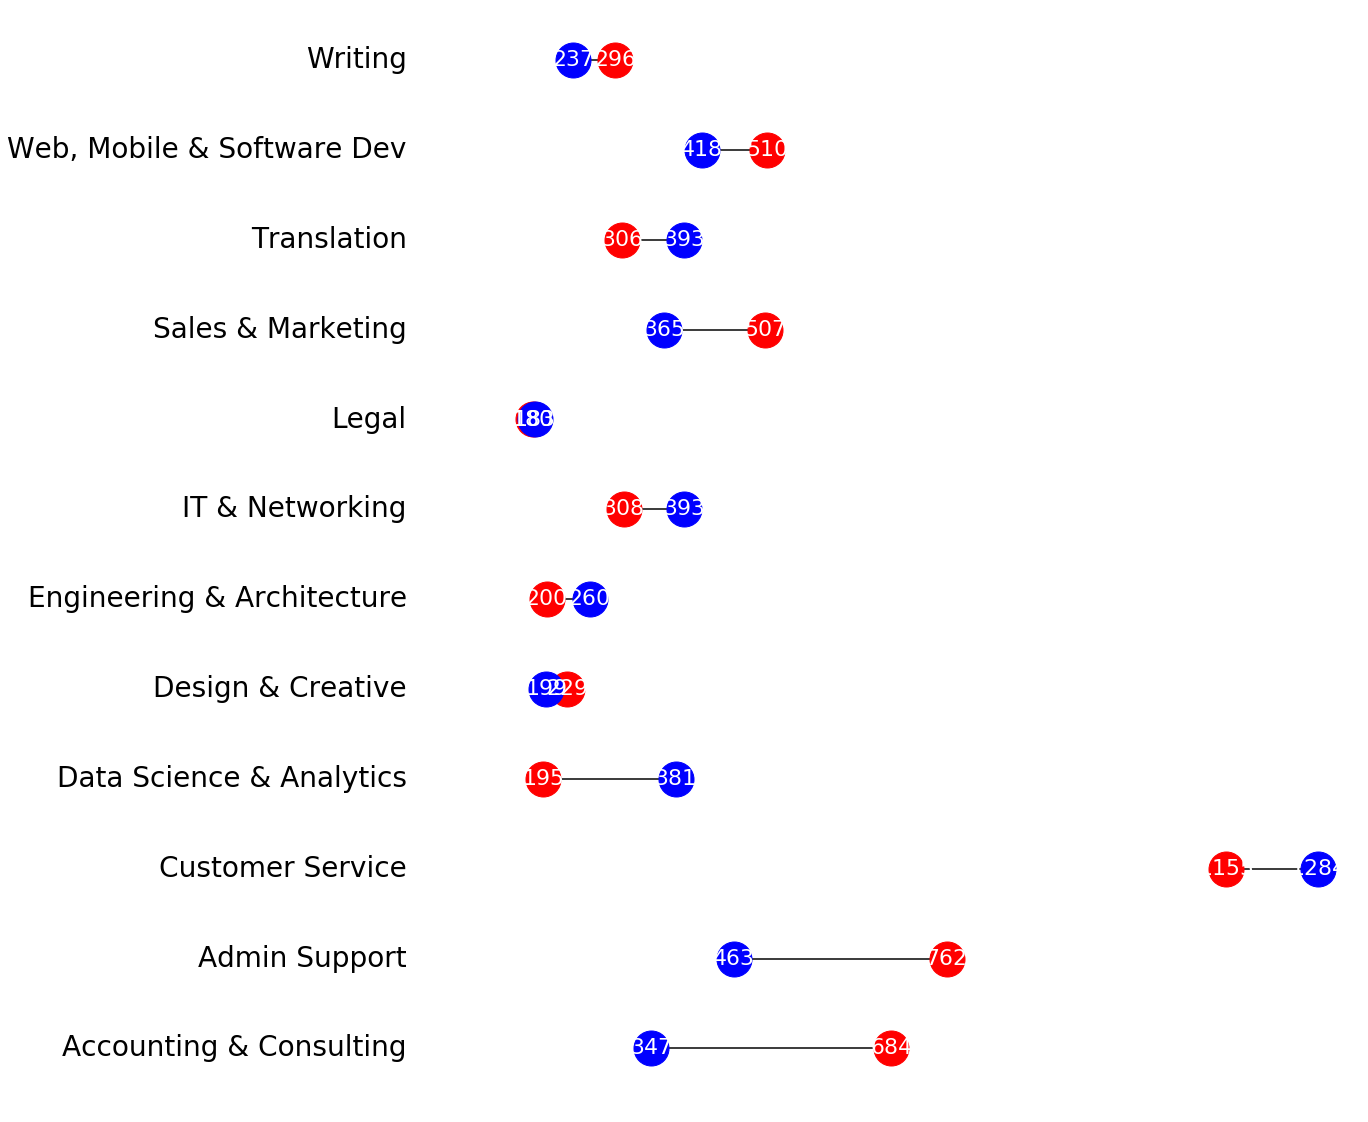

In [23]:
create_barbell_chart(merged_active, 'hours_worked')

## Number of Jobs Completed by Gender

In [17]:
merged['jobs_completed'] = merged['jobs_completed'].astype('float')
merged_have_worked = merged[merged['jobs_completed'] > 0]

print ("Total number of active users: {0}".format(len(merged_have_worked)))
print ("Number of female active users: {0}".format(len(merged_have_worked[merged_have_worked['gender_computer'] == 'female'])))
print ("Number of male active users: {0}".format(len(merged_have_worked[merged_have_worked['gender_computer'] == 'male'])))

sd = np.std(merged_have_worked['jobs_completed'])
mean = np.mean(merged_have_worked['jobs_completed'])
median = np.median(merged_have_worked['jobs_completed'])
print("Jobs completed average: {0}".format(mean))
print("Jobs completed standard deviation: {0}".format(sd))
print("Jobs completed median: {0}".format(median))

table = merged_have_worked.groupby('gender_computer')['jobs_completed'].mean()
print ("Average jobs completed")
print (table)

table= merged_have_worked.groupby('gender_computer')['jobs_completed'].median()
print ("Median jobs completed")
print (table)

table= merged_have_worked.groupby('gender_computer')['jobs_completed'].std()
print ("Standard deviation of jobs completed")
print (table)

Total number of active users: 13987
Number of female active users: 7205
Number of male active users: 6782
Jobs completed average: 17.1092442983
Jobs completed standard deviation: 50.3551163277
Jobs completed median: 4.0
Average jobs completed
gender_computer
female    19.008883
male      15.091124
Name: jobs_completed, dtype: float64
Median jobs completed
gender_computer
female    4.0
male      3.0
Name: jobs_completed, dtype: float64
Standard deviation of jobs completed
gender_computer
female    57.021681
male      42.047469
Name: jobs_completed, dtype: float64


In [18]:
merged_have_worked['no_reviews'] = merged_have_worked['no_reviews'].astype('float')

sd = np.std(merged_have_worked['no_reviews'])
mean = np.mean(merged_have_worked['no_reviews'])
median = np.median(merged_have_worked['no_reviews'])
print("Reviews average: {0}".format(mean))
print("Reviews standard deviation: {0}".format(sd))
print("Reviews median: {0}".format(median))

table = merged_have_worked.groupby('gender_computer')['no_reviews'].mean()
print ("Average reviews")
print (table)

table= merged_have_worked.groupby('gender_computer')['no_reviews'].median()
print ("Median reviews")
print (table)

table= merged_have_worked.groupby('gender_computer')['no_reviews'].std()
print ("Standard deviation of reviews")
print (table)

Reviews average: 11.0472581683
Reviews standard deviation: 31.5774043134
Reviews median: 2.0
Average reviews
gender_computer
female    12.007217
male      10.027426
Name: no_reviews, dtype: float64
Median reviews
gender_computer
female    2.0
male      2.0
Name: no_reviews, dtype: float64
Standard deviation of reviews
gender_computer
female    35.012133
male      27.430326
Name: no_reviews, dtype: float64


/home/ecf384/.conda/envs/eureka2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## Jobs Completed by Job Category

[12, 16, 11, 8, 19, 11, 7, 28, 19, 24, 15, 22]
[12, 12, 8, 10, 16, 8, 12, 39, 17, 27, 12, 19]


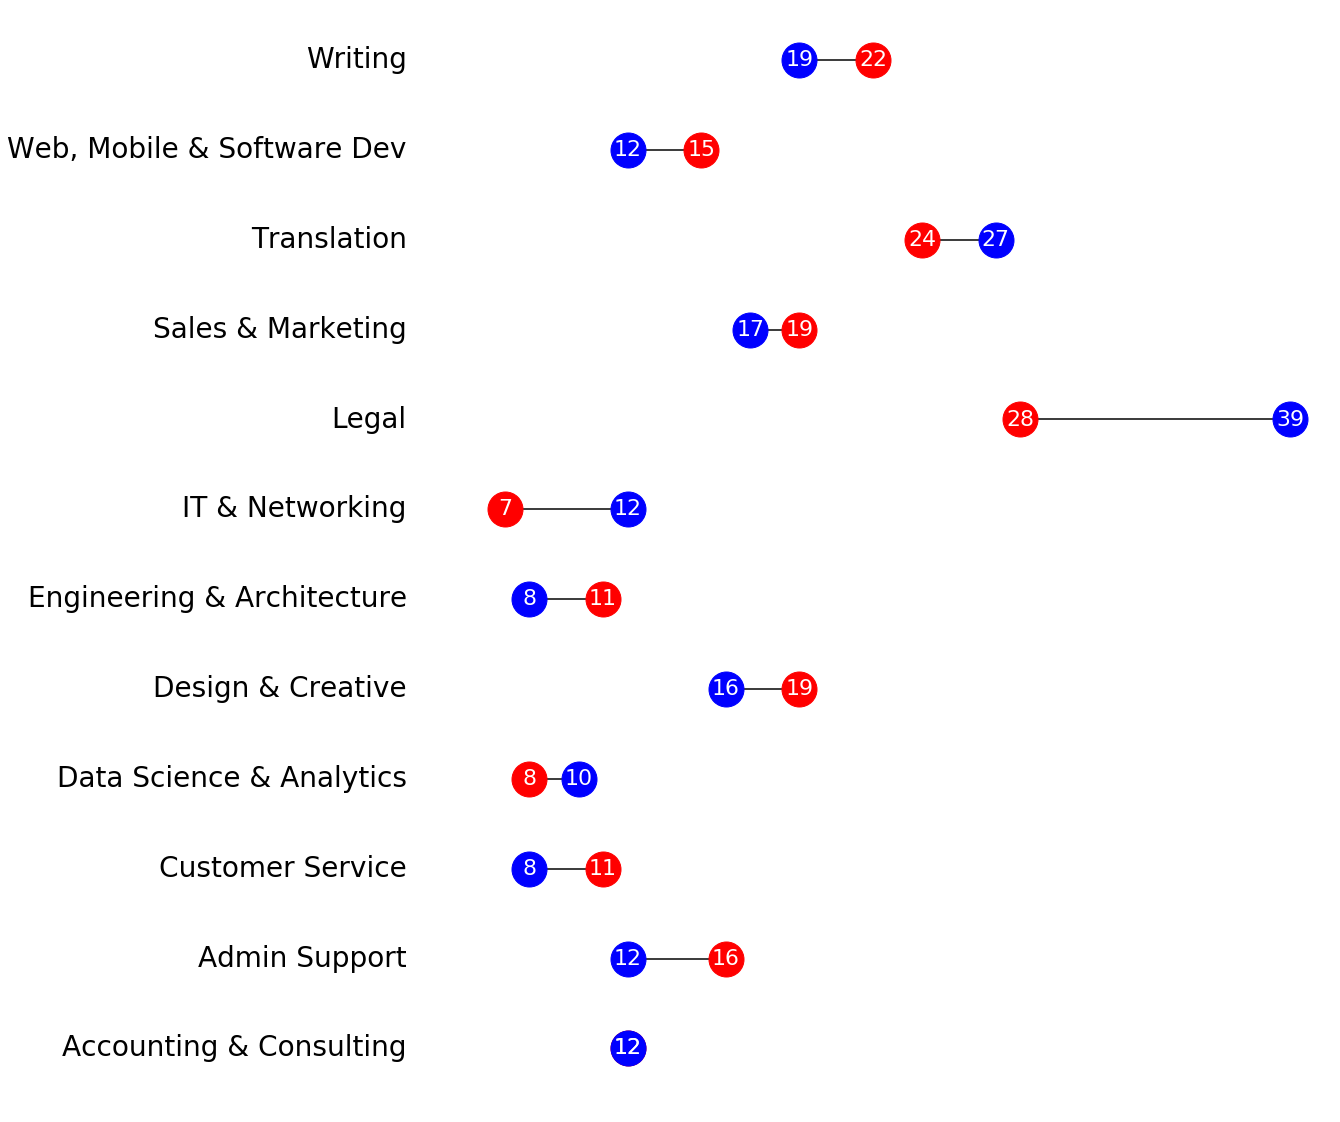

In [24]:
create_barbell_chart(merged_have_worked, 'jobs_completed')

## Number of Reviews by Job Category

[7, 9, 7, 5, 13, 7, 4, 11, 11, 15, 10, 14]
[7, 8, 5, 6, 11, 5, 7, 26, 11, 18, 8, 13]


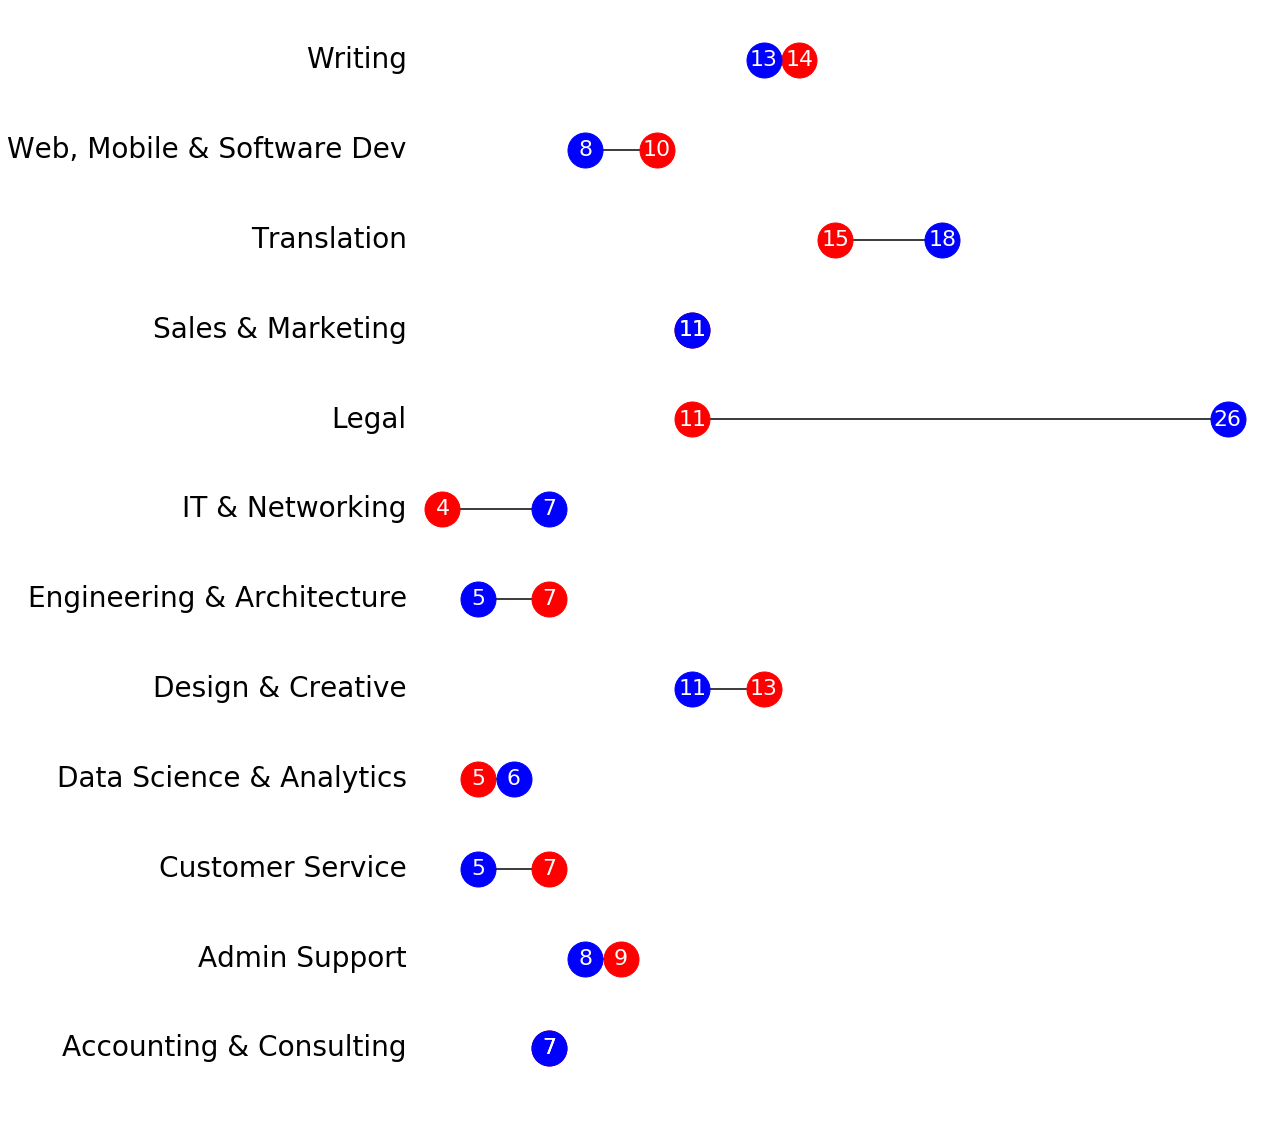

In [25]:
create_barbell_chart(merged_have_worked, 'no_reviews')